<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20MedTextDataset%20LDA%20and%20GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

Loading medical dataset...
Loaded 594 medical-related documents in 1.332s.
Extracting tf-idf features for NMF...
done in 0.102s.
Extracting tf features for LDA...
done in 0.100s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=594 and n_features=1000...
done in 0.123s.


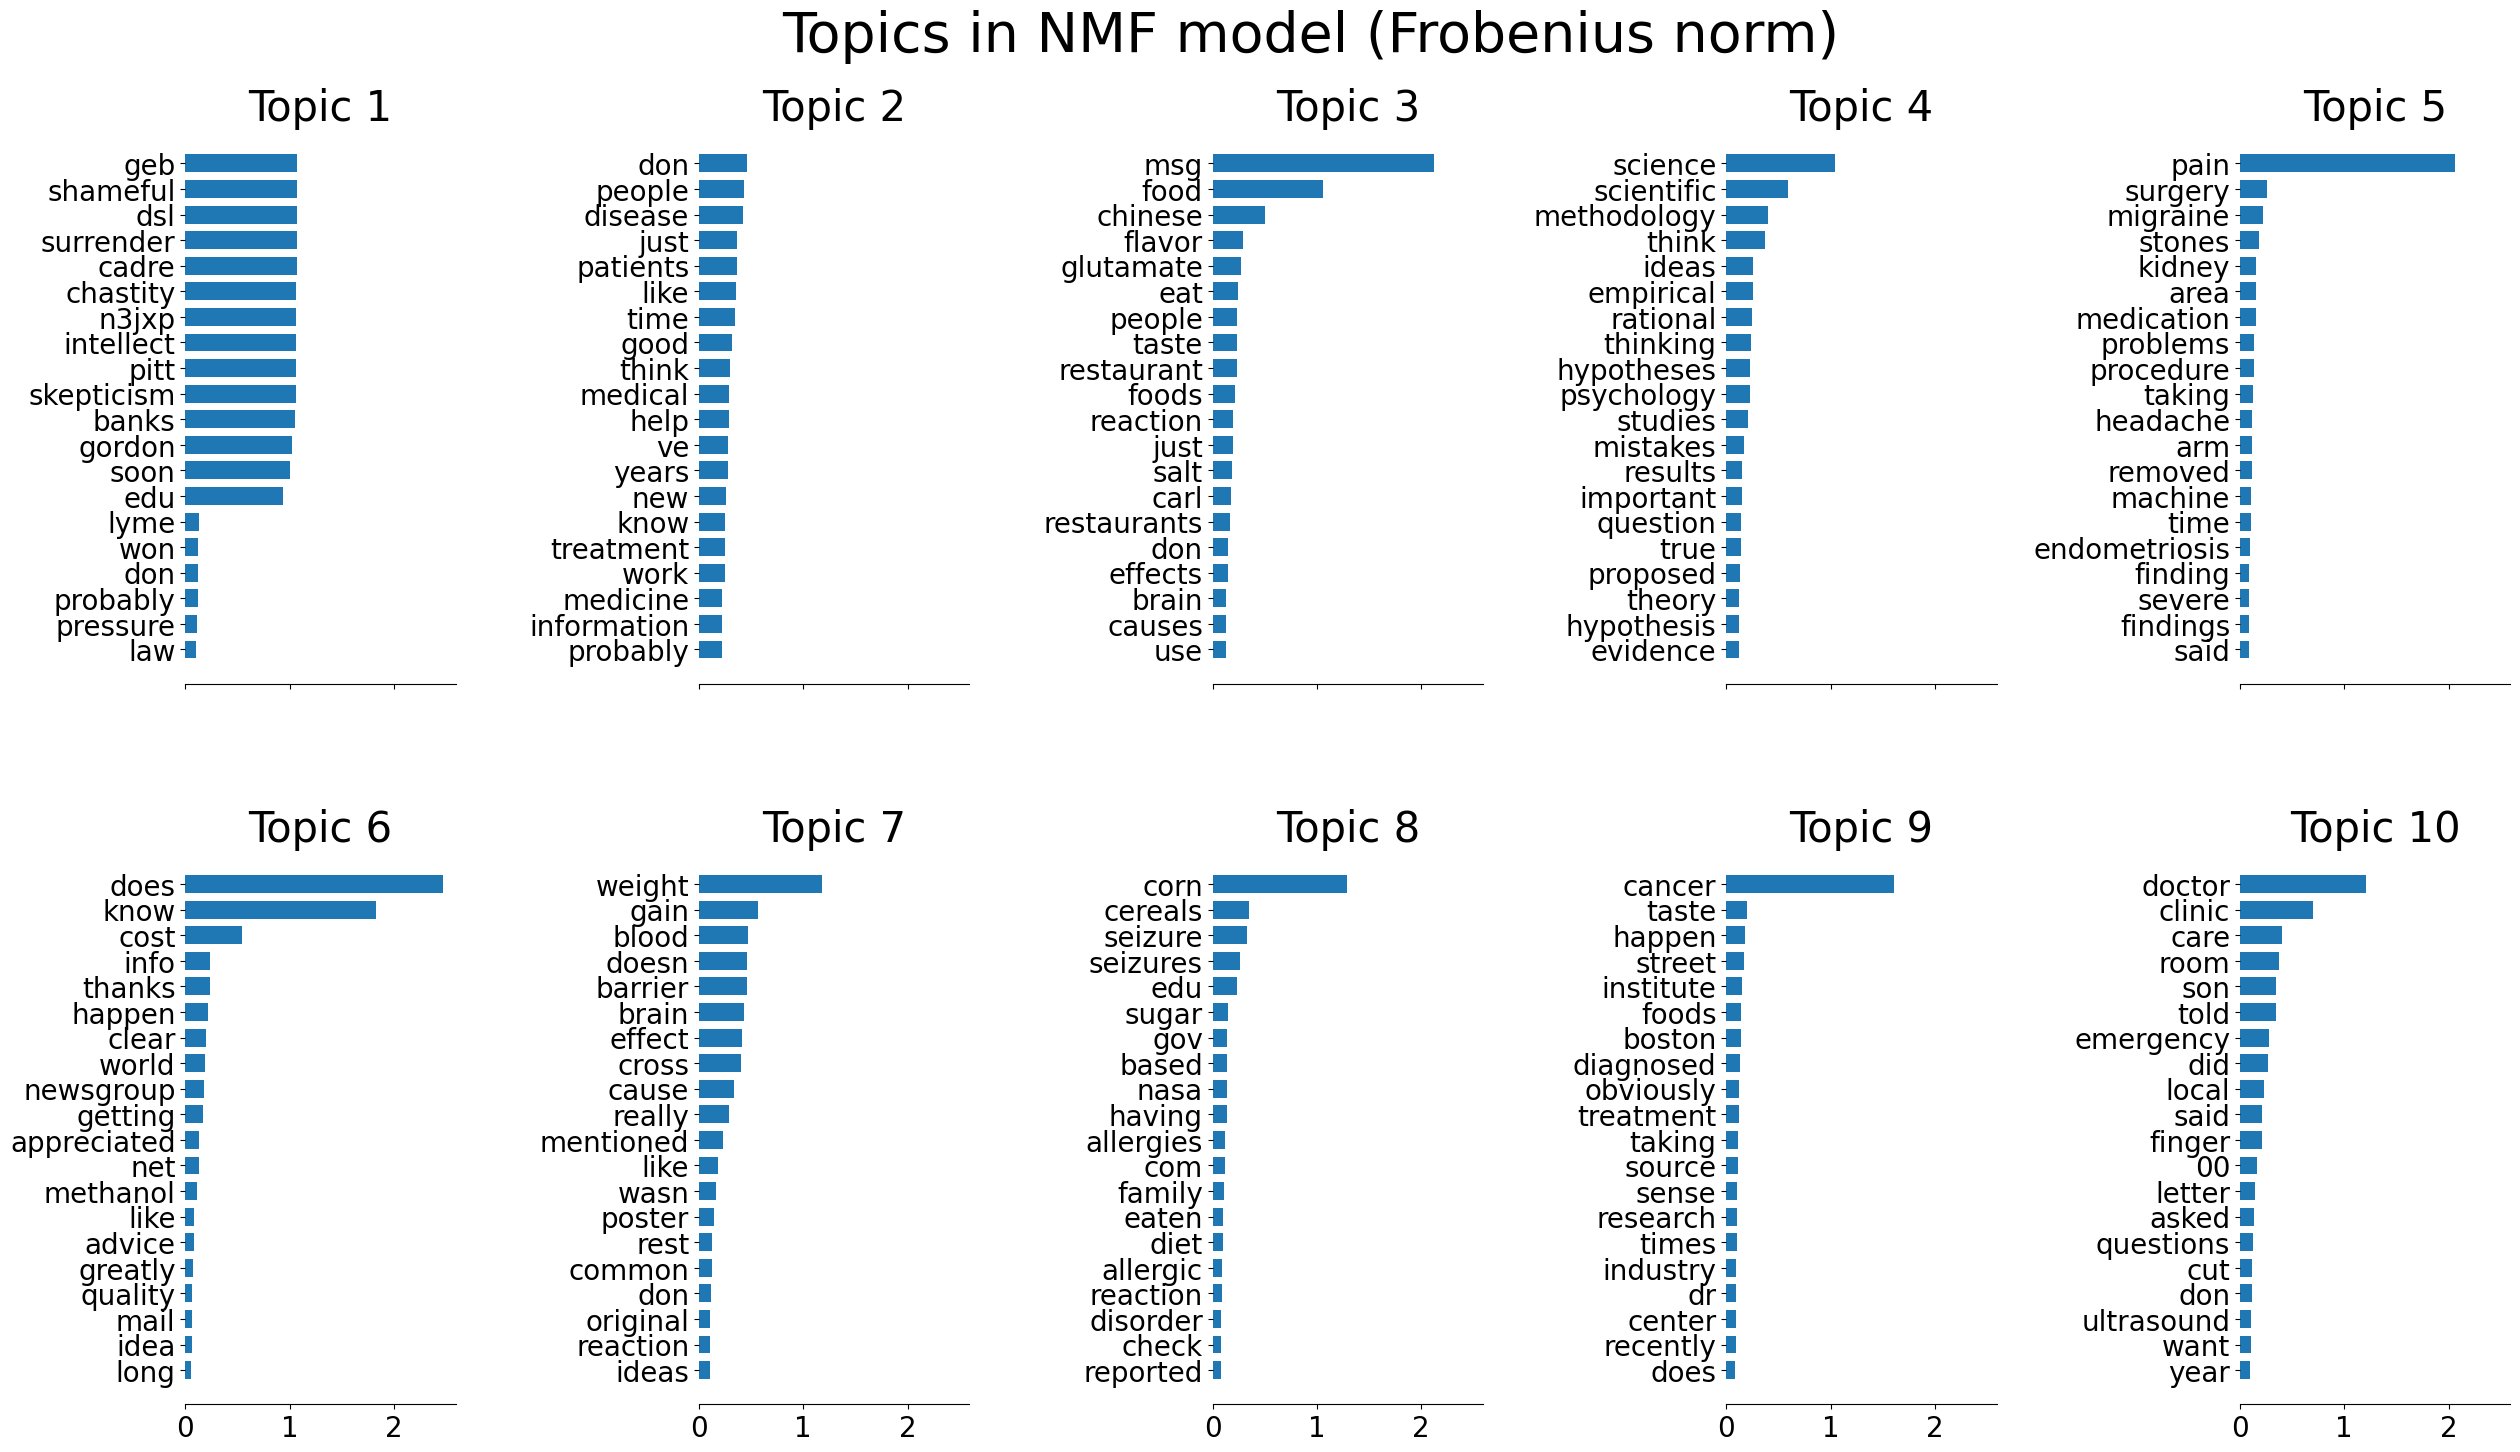



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=594 and n_features=1000...
done in 0.861s.


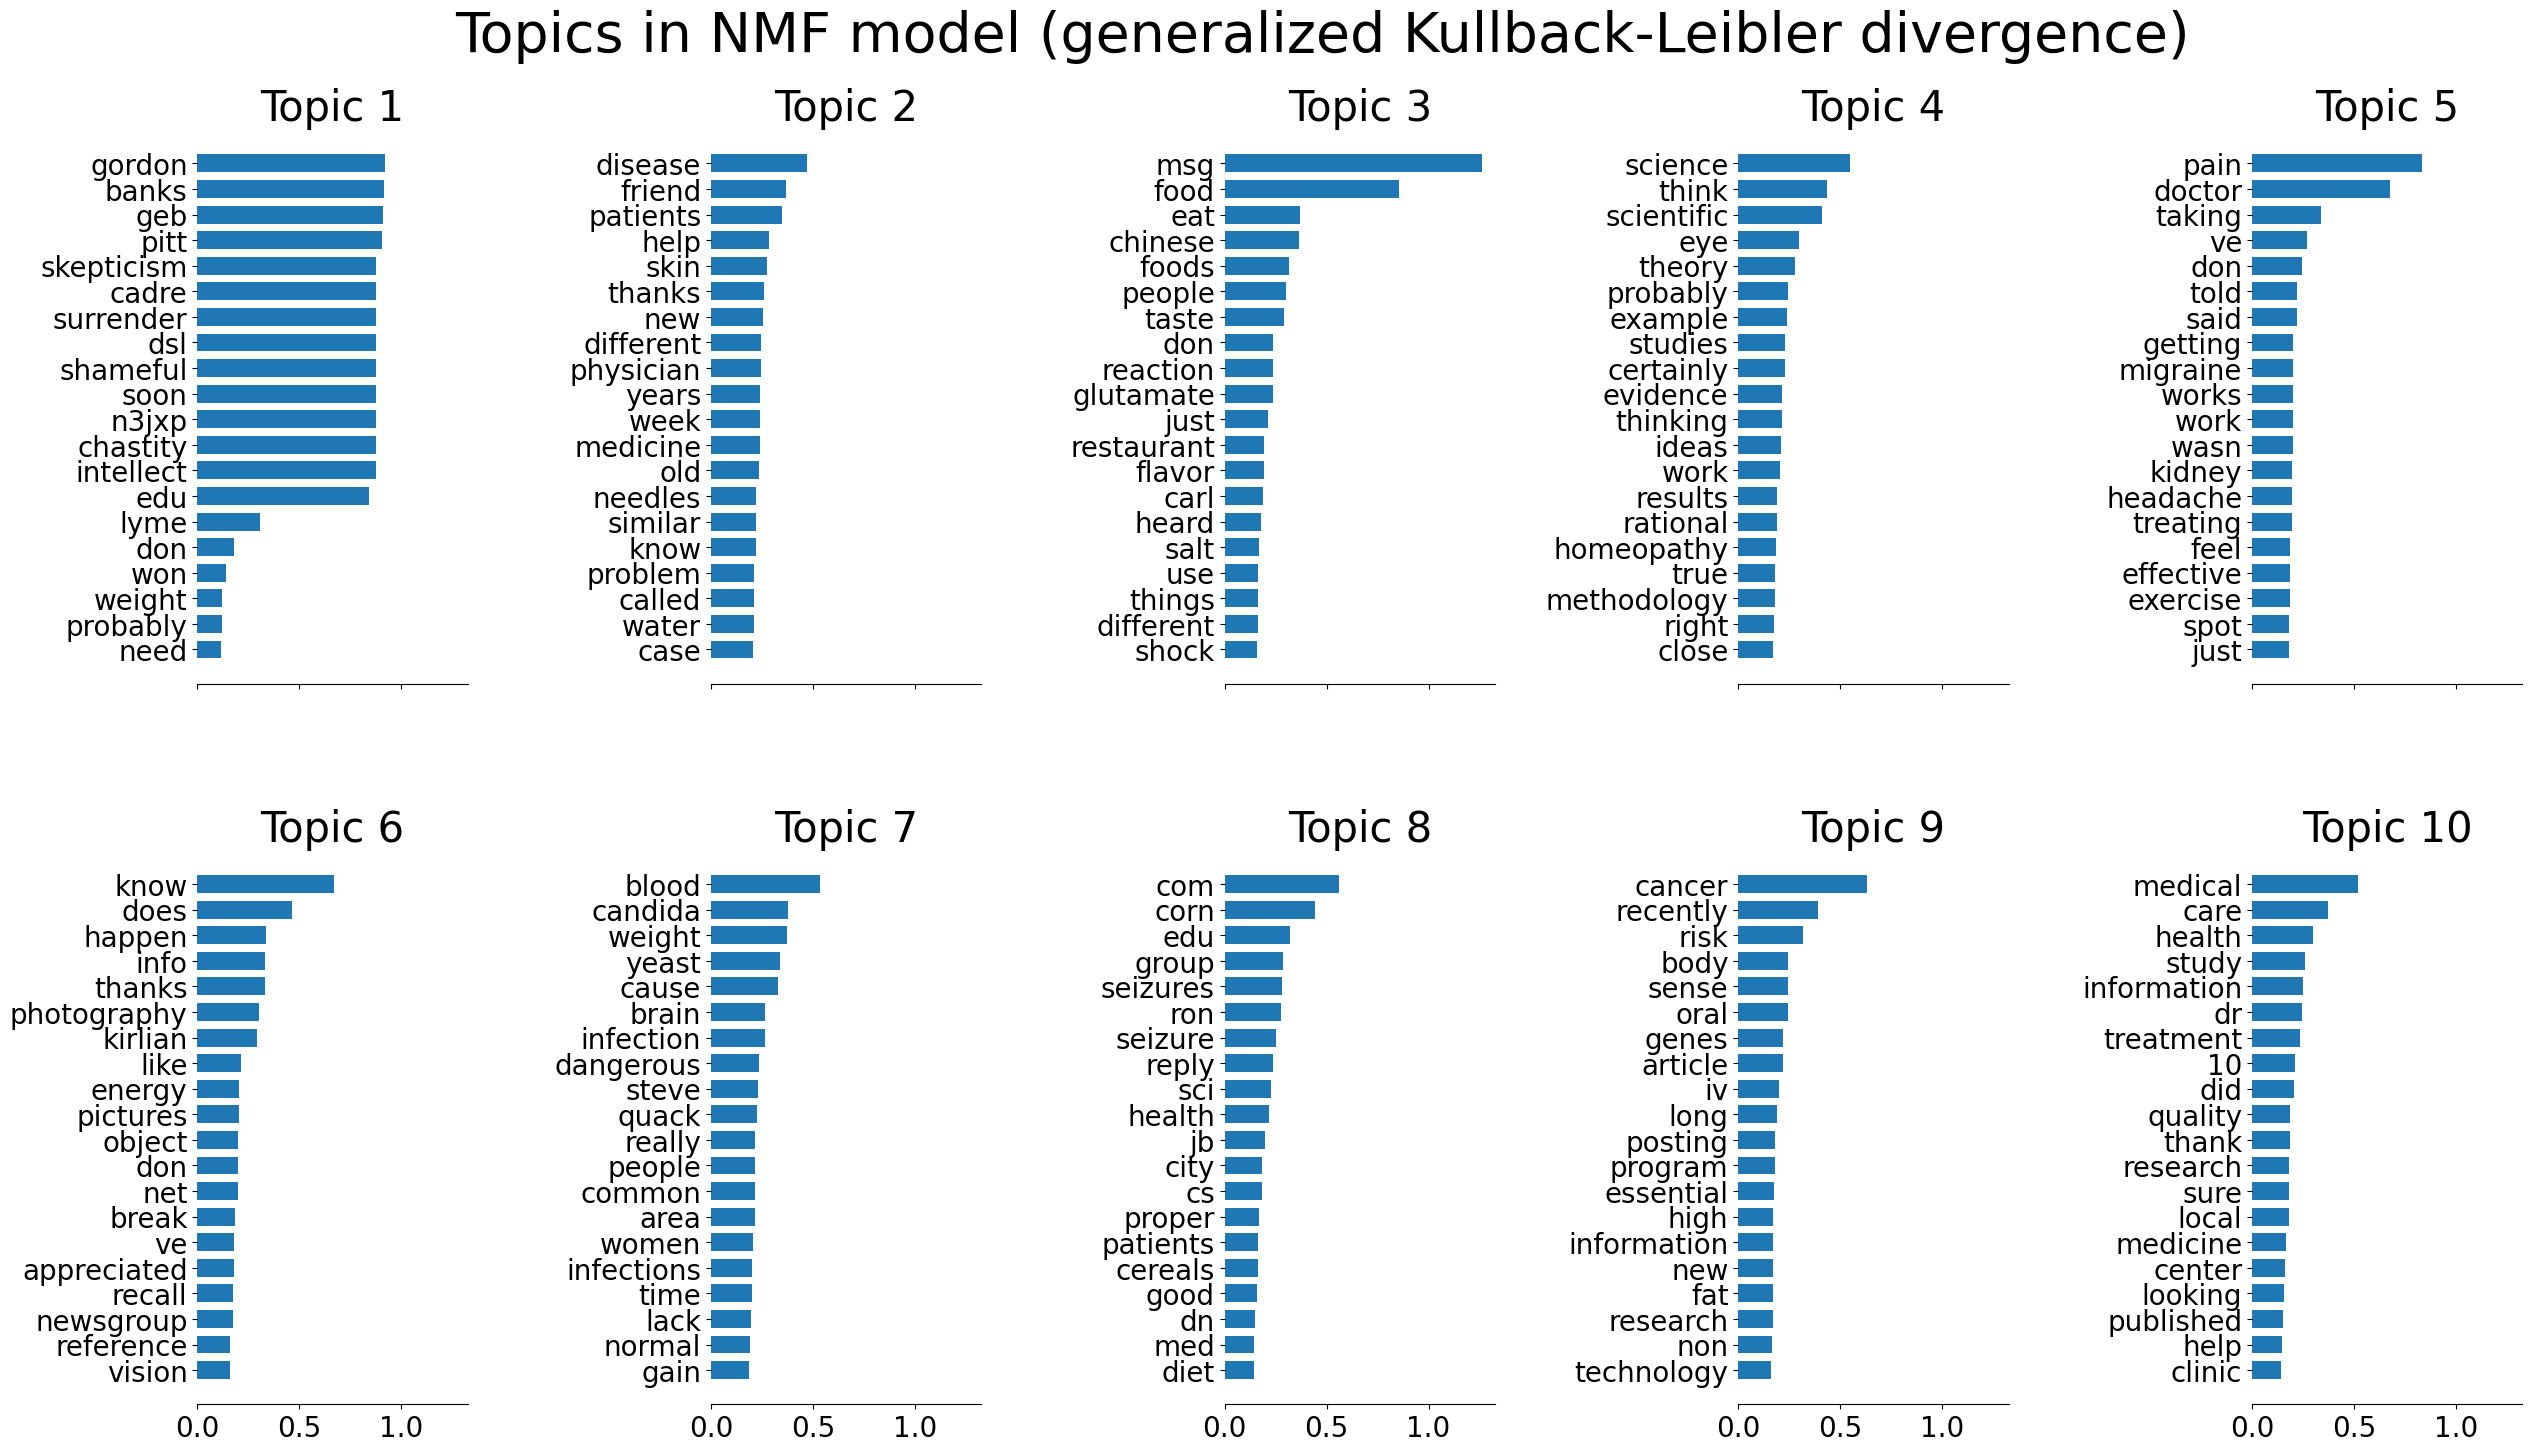



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=594 and n_features=1000, batch_size=128...
done in 1.006s.


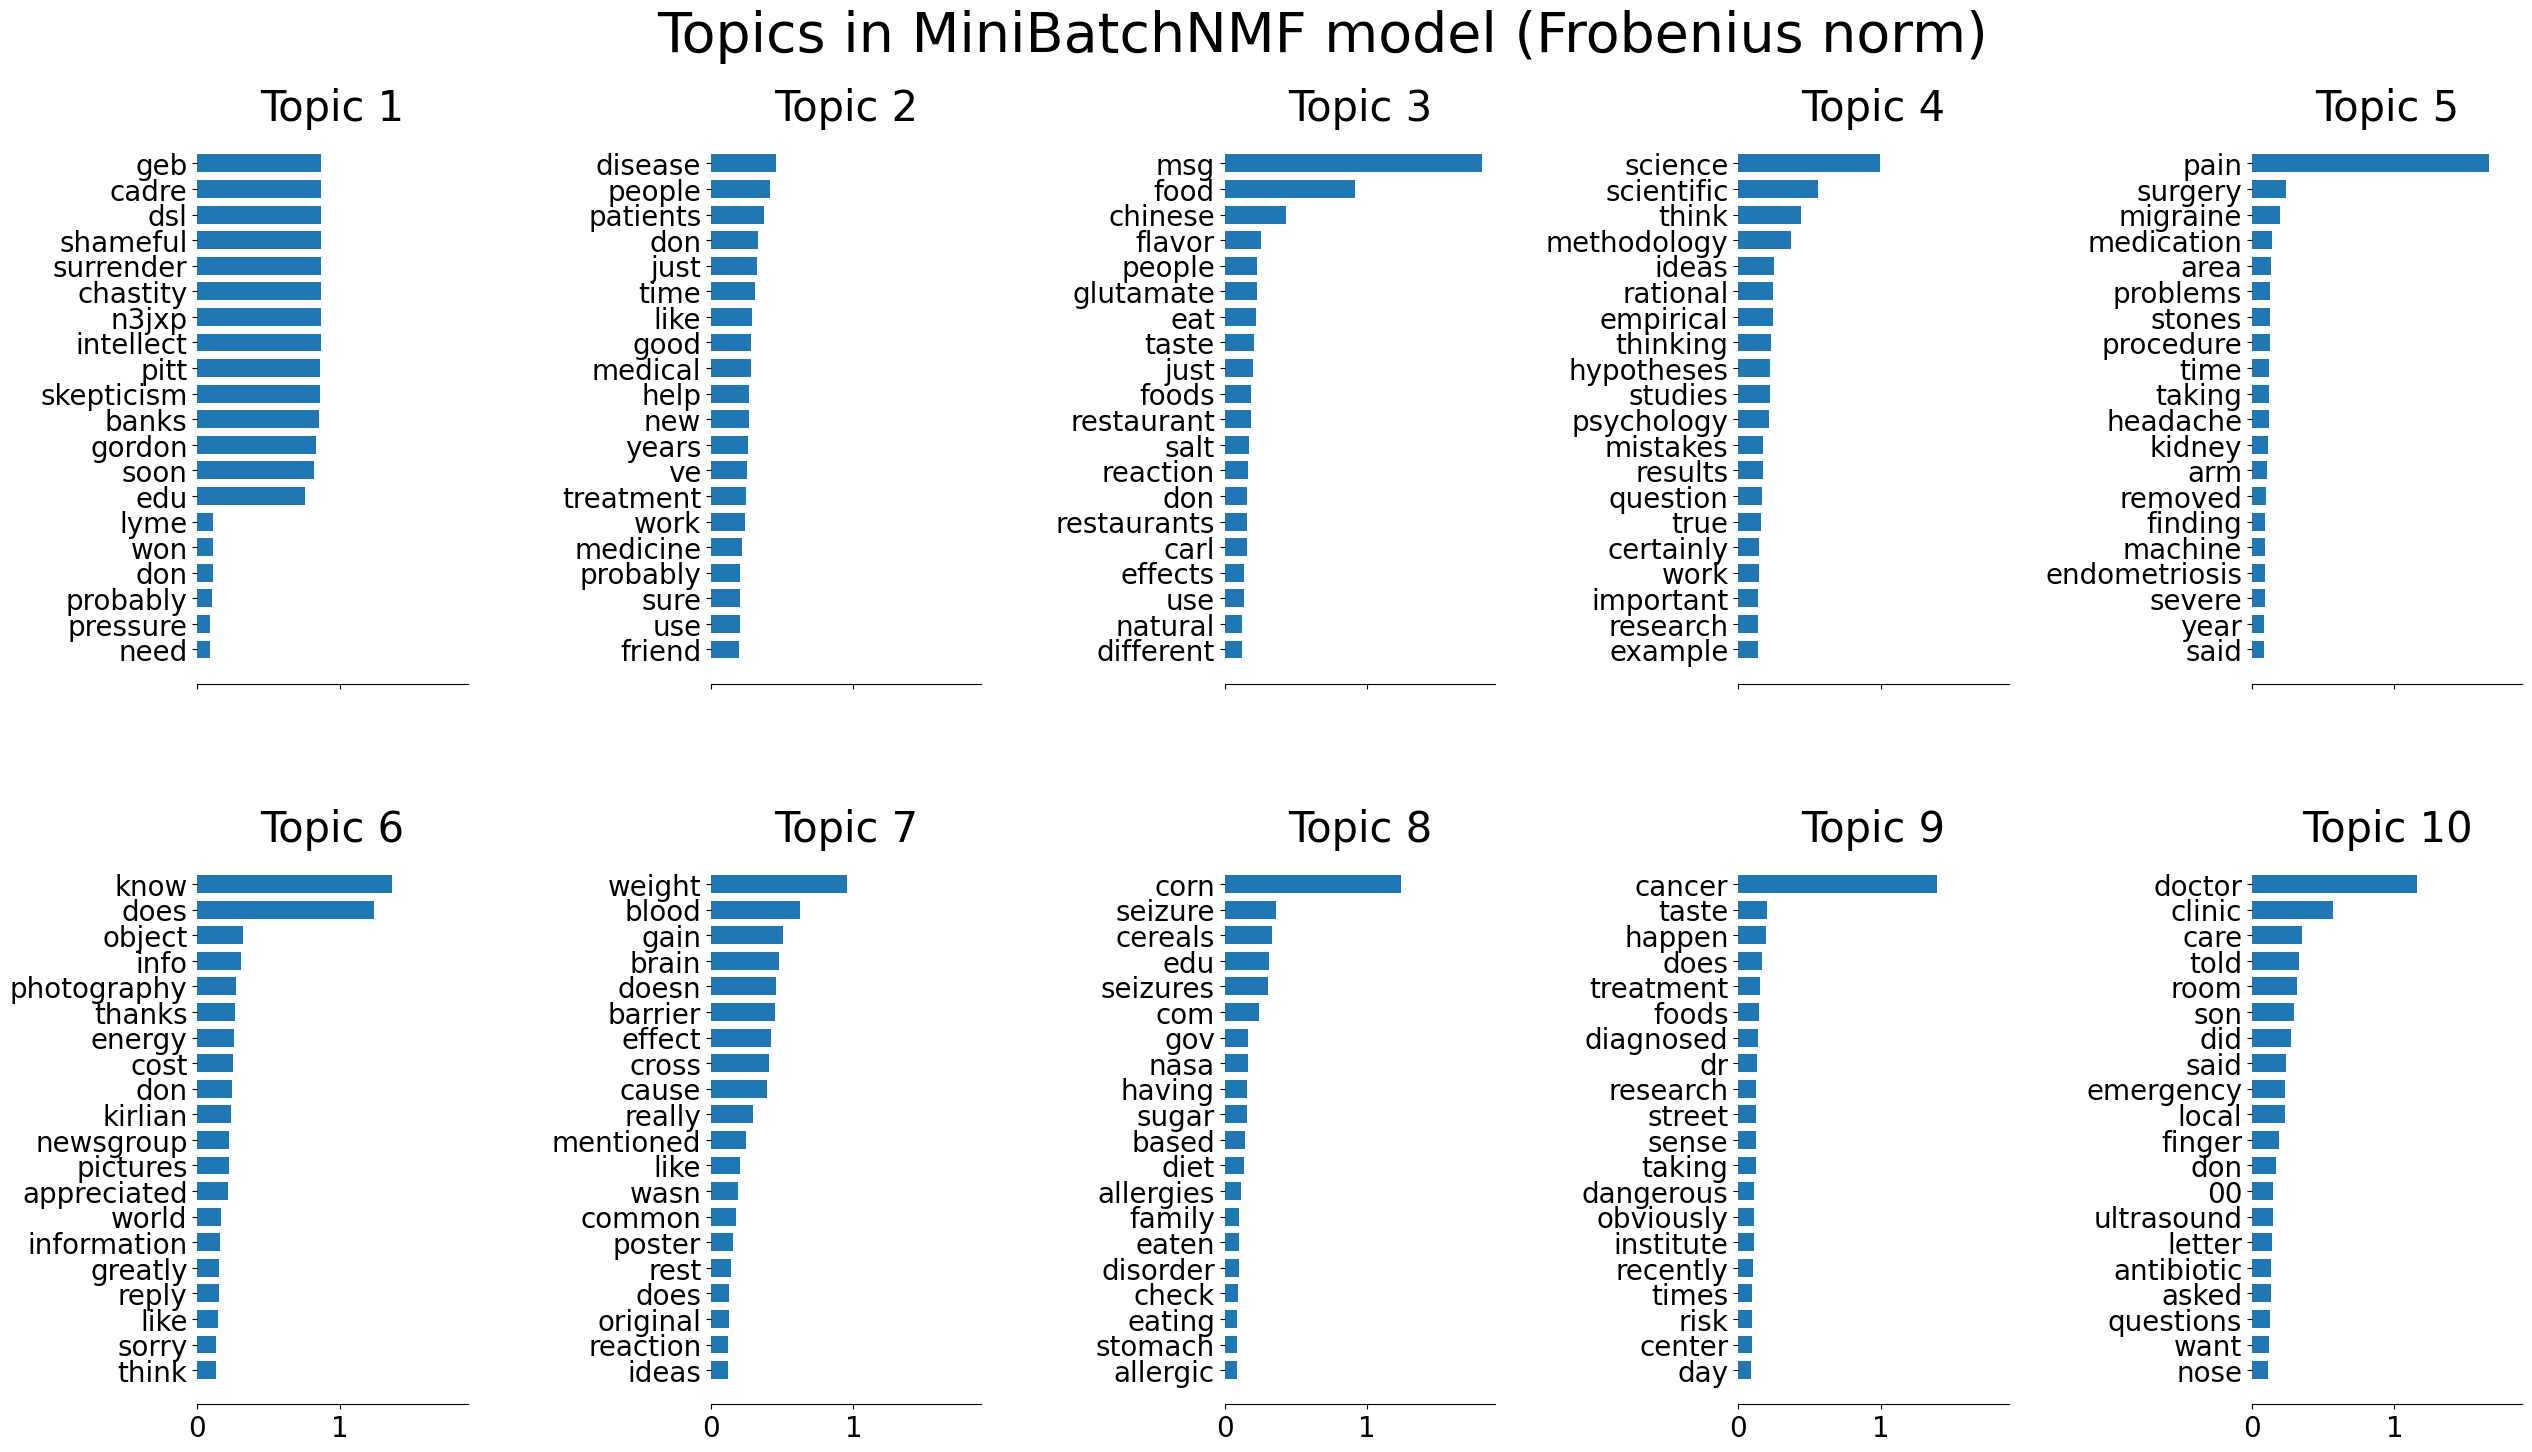



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=594 and n_features=1000, batch_size=128...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:2328: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 3.333s.


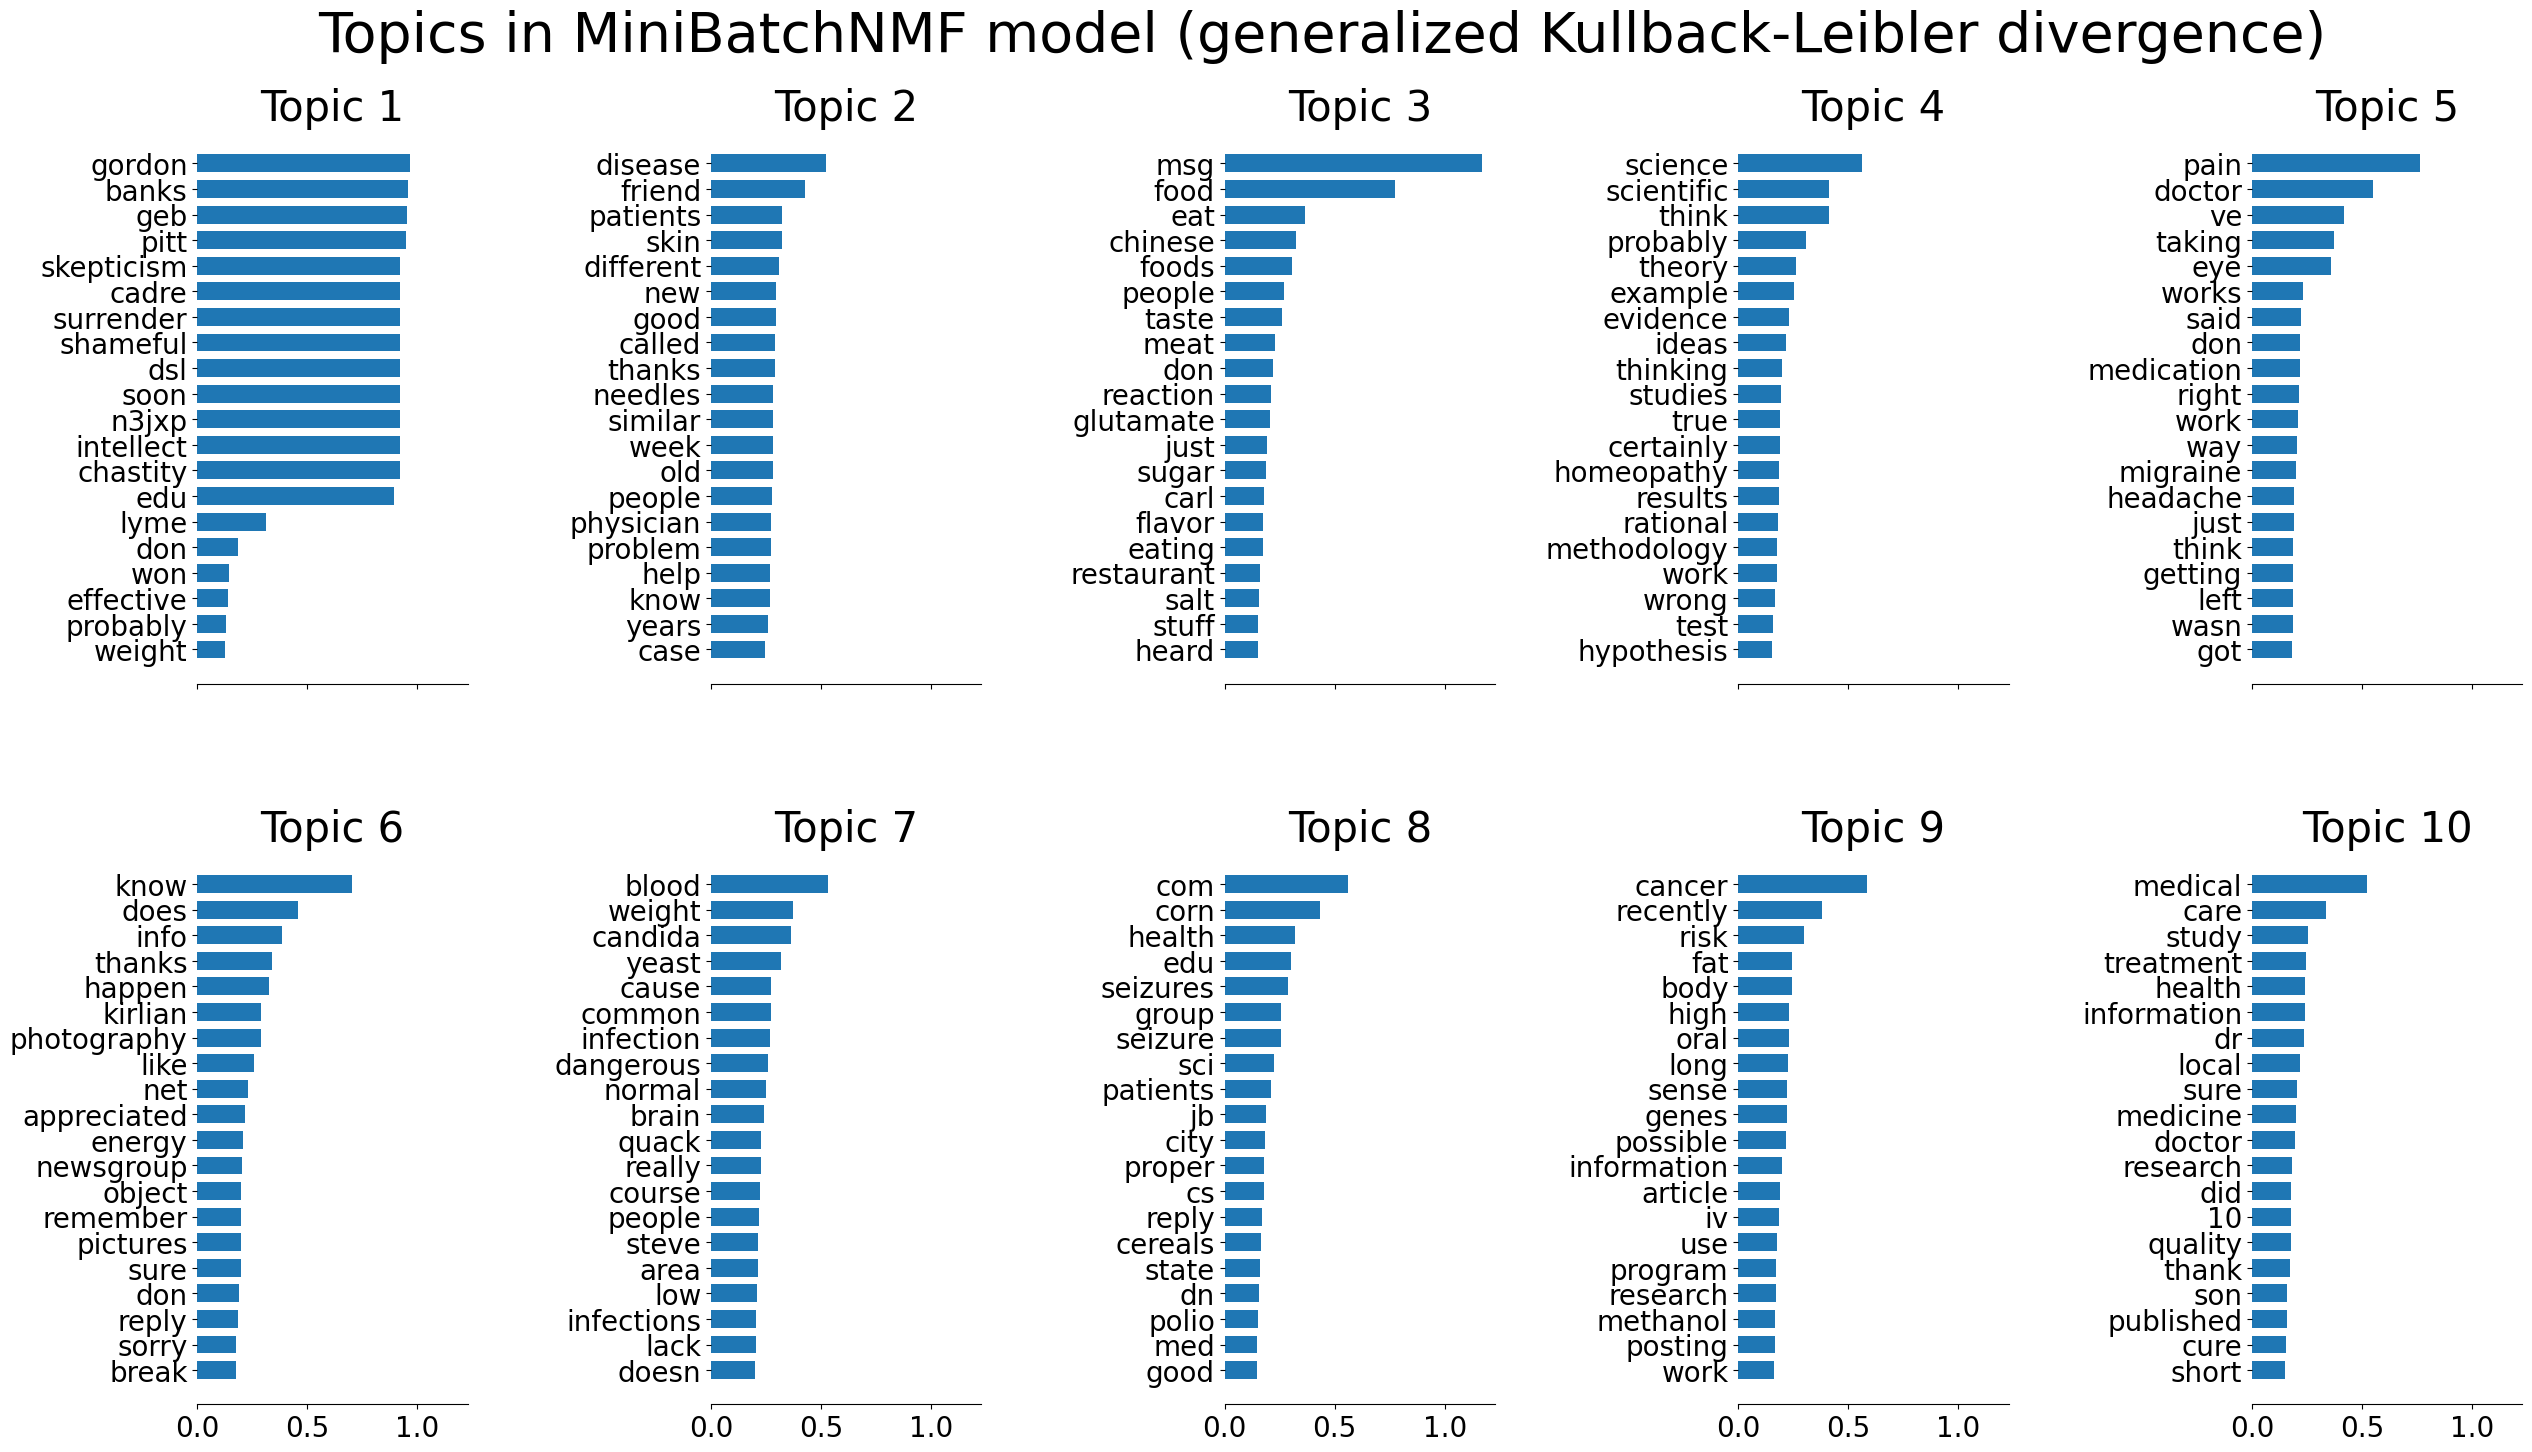



 Fitting LDA models with tf features, n_samples=594 and n_features=1000...
done in 0.890s.


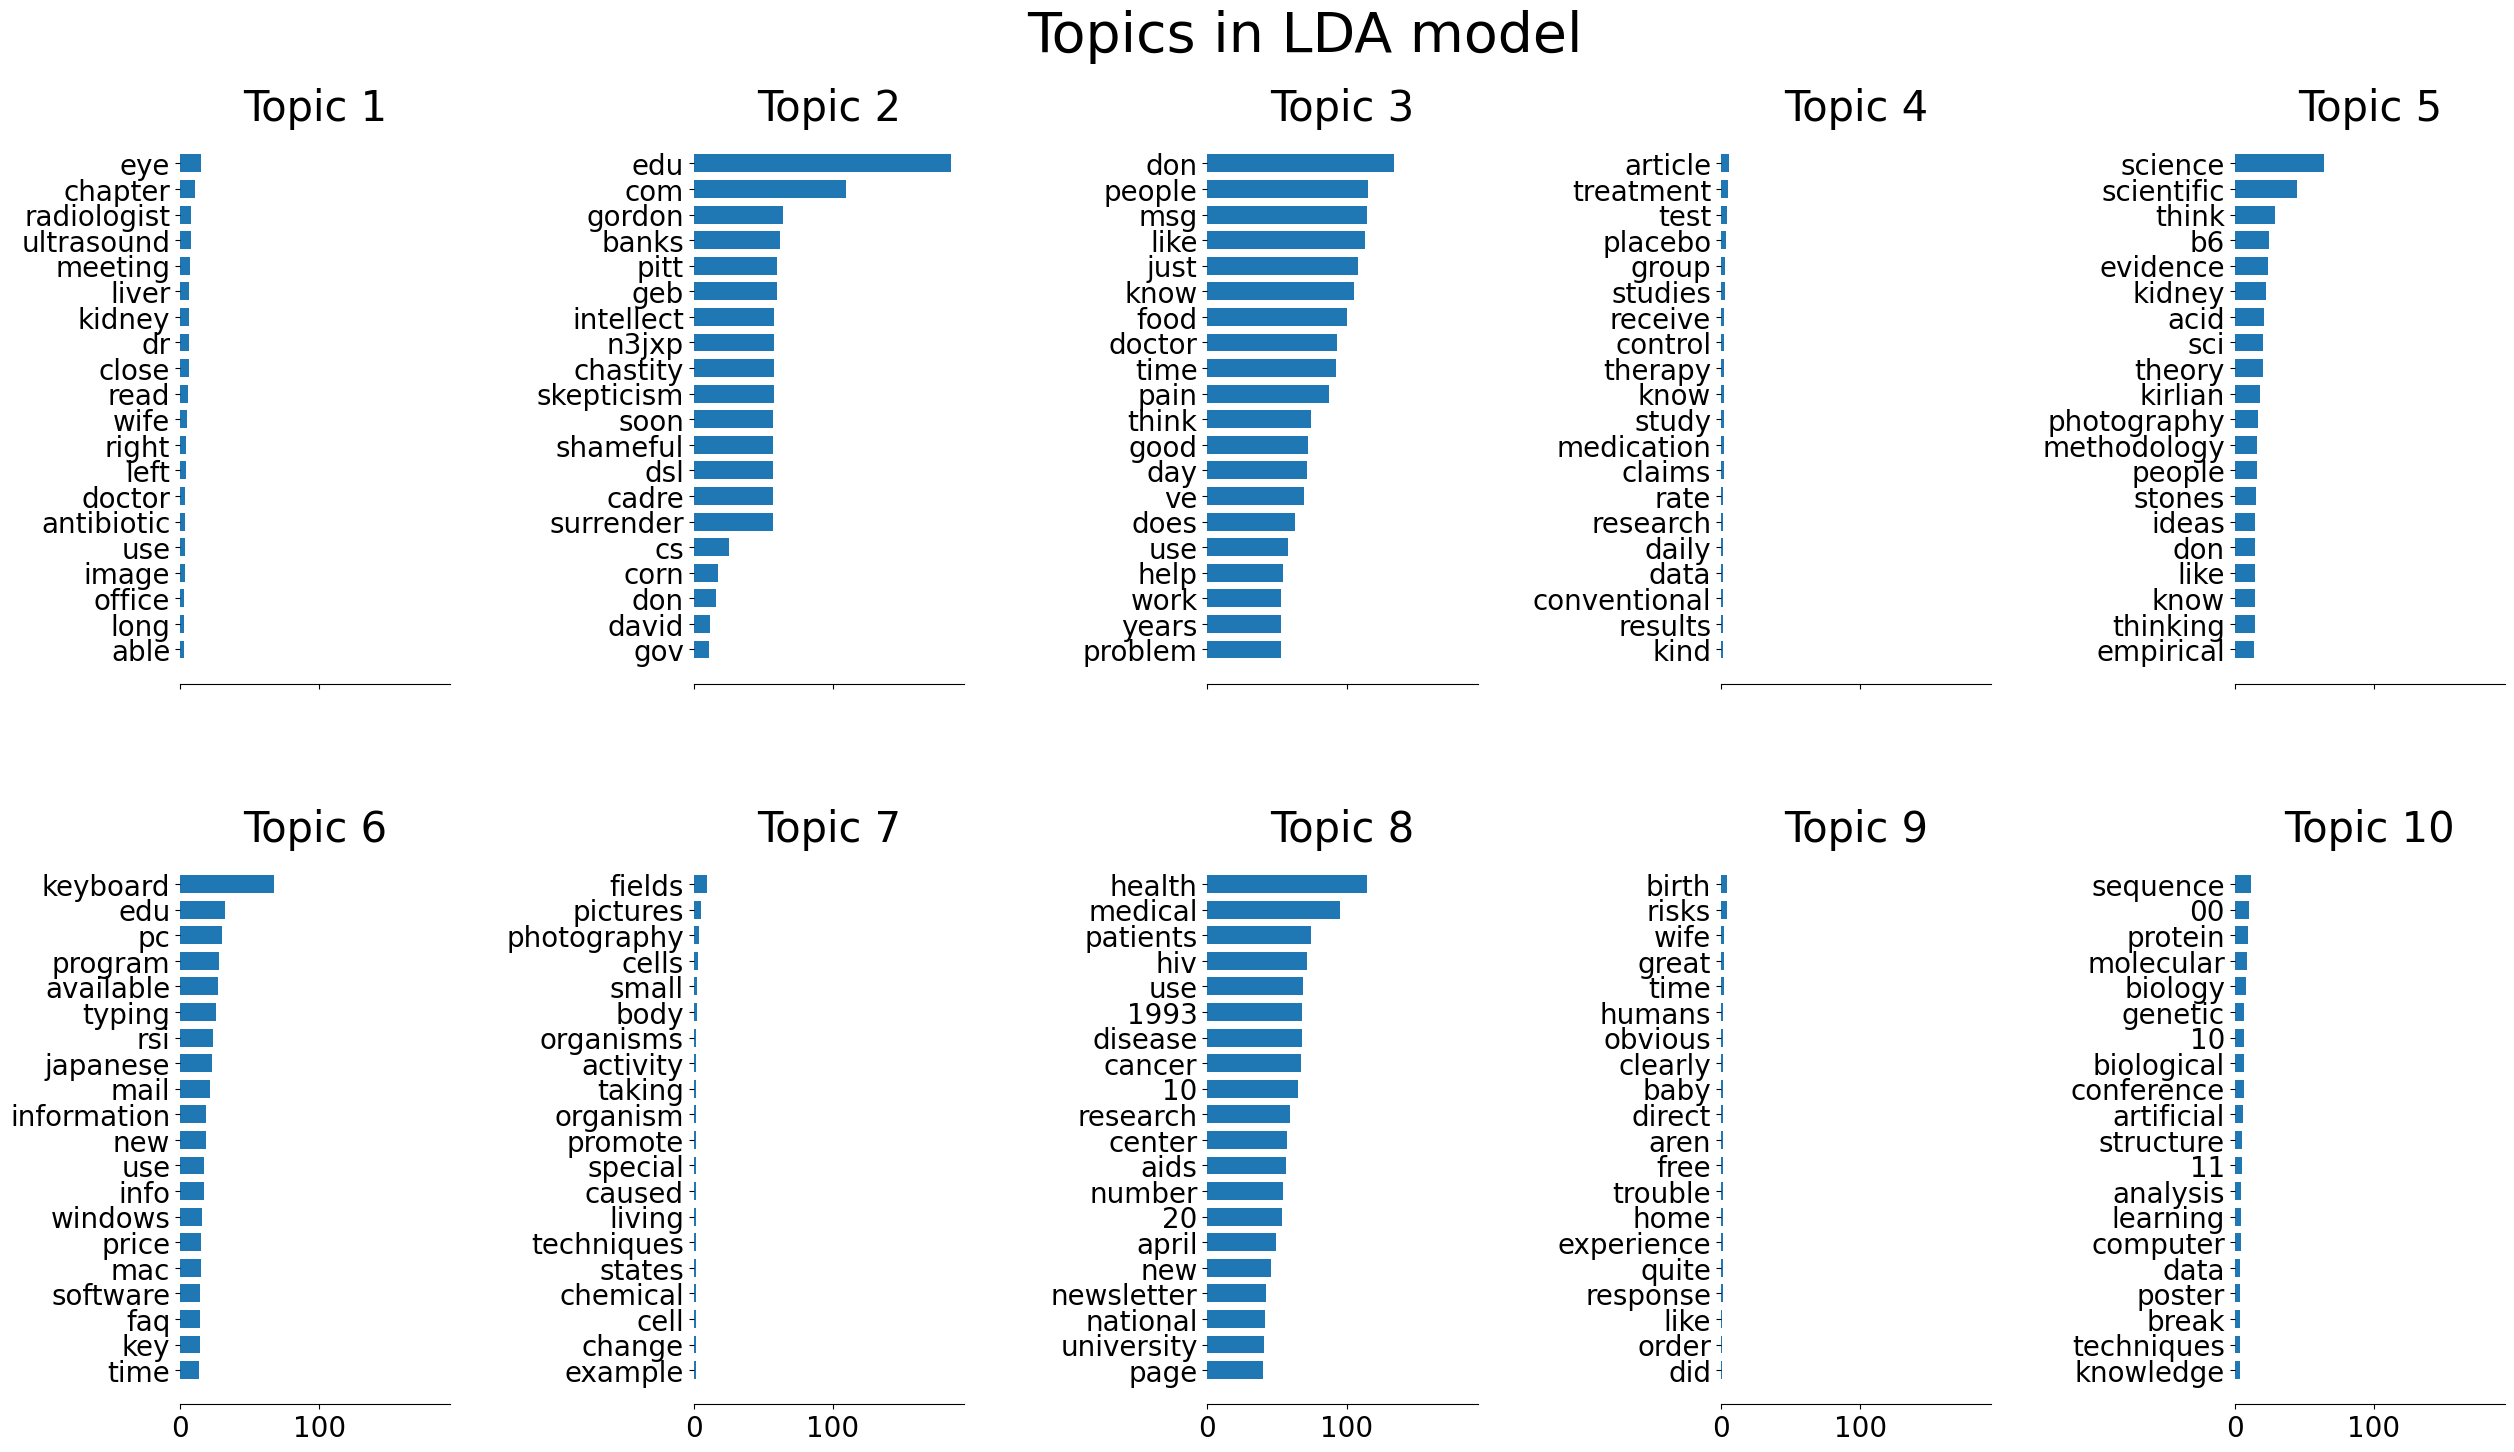

In [ ]:
# Authors: The scikit-learn developers (modified for medical data)
# SPDX-License-Identifier: BSD-3-Clause

from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np

# Load a medical dataset - using 20newsgroups but filtering for medical-related categories
# Alternatively, you could load from a medical text corpus like PubMed abstracts
print("Loading medical dataset...")
t0 = time()

# Fetch medical-related newsgroups
medical_categories = ['sci.med'] #, 'misc.forsale', 'talk.politics.misc']  # Using sci.med primarily
try:
    # Try to fetch with medical categories
    data, target = fetch_20newsgroups(
        shuffle=True,
        random_state=1,
        remove=("headers", "footers", "quotes"),
        categories=['sci.med'],  # Focus on medical content
        return_X_y=True,
    )
except ValueError:
    # If specific medical category not available, use all and filter
    data, target = fetch_20newsgroups(
        shuffle=True,
        random_state=1,
        remove=("headers", "footers", "quotes"),
        return_X_y=True,
    )
    # Filter for medical-related content based on keywords
    medical_keywords = ['medical', 'doctor', 'patient', 'health', 'disease', 'treatment', 'medicine', 'hospital', 'symptom', 'therapy', 'clinical', 'pharmaceutical', 'drug', 'therapy', 'surgery', 'diagnosis']
    medical_mask = [any(keyword in text.lower() for keyword in medical_keywords) for text in data]
    data = [data[i] for i in range(len(data)) if medical_mask[i]]

n_samples = min(2000, len(data))  # Adjust if fewer samples available
data_samples = data[:n_samples]

print(f"Loaded {n_samples} medical-related documents in %0.3fs." % (time() - t0))

# Parameters
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_features,
    stop_words="english",
    # Add medical-specific preprocessor if needed
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_features,
    stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [ ]:
data_samples[1:3]


["According to a previous poster, one should seek a doctor's\nassistance for injections. But what about Sumatriptin [sp?]?\nDoesn't one have to inject oneself immediately upon the onset\nof a migraine?\n\n",
 '\nReflex sympathetic dystrophy.  I\'m sure there\'s an FAQ, as I have\nmade at least 10 answers to questions on it in the last year or so.\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." ']

# Graph visualisation

Loading medical dataset...
Loaded 594 medical-related documents in 4.141s.
Extracting tf-idf features for NMF...
done in 0.559s.
Extracting tf features for LDA...
done in 0.281s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=594 and n_features=1000...
done in 0.381s.


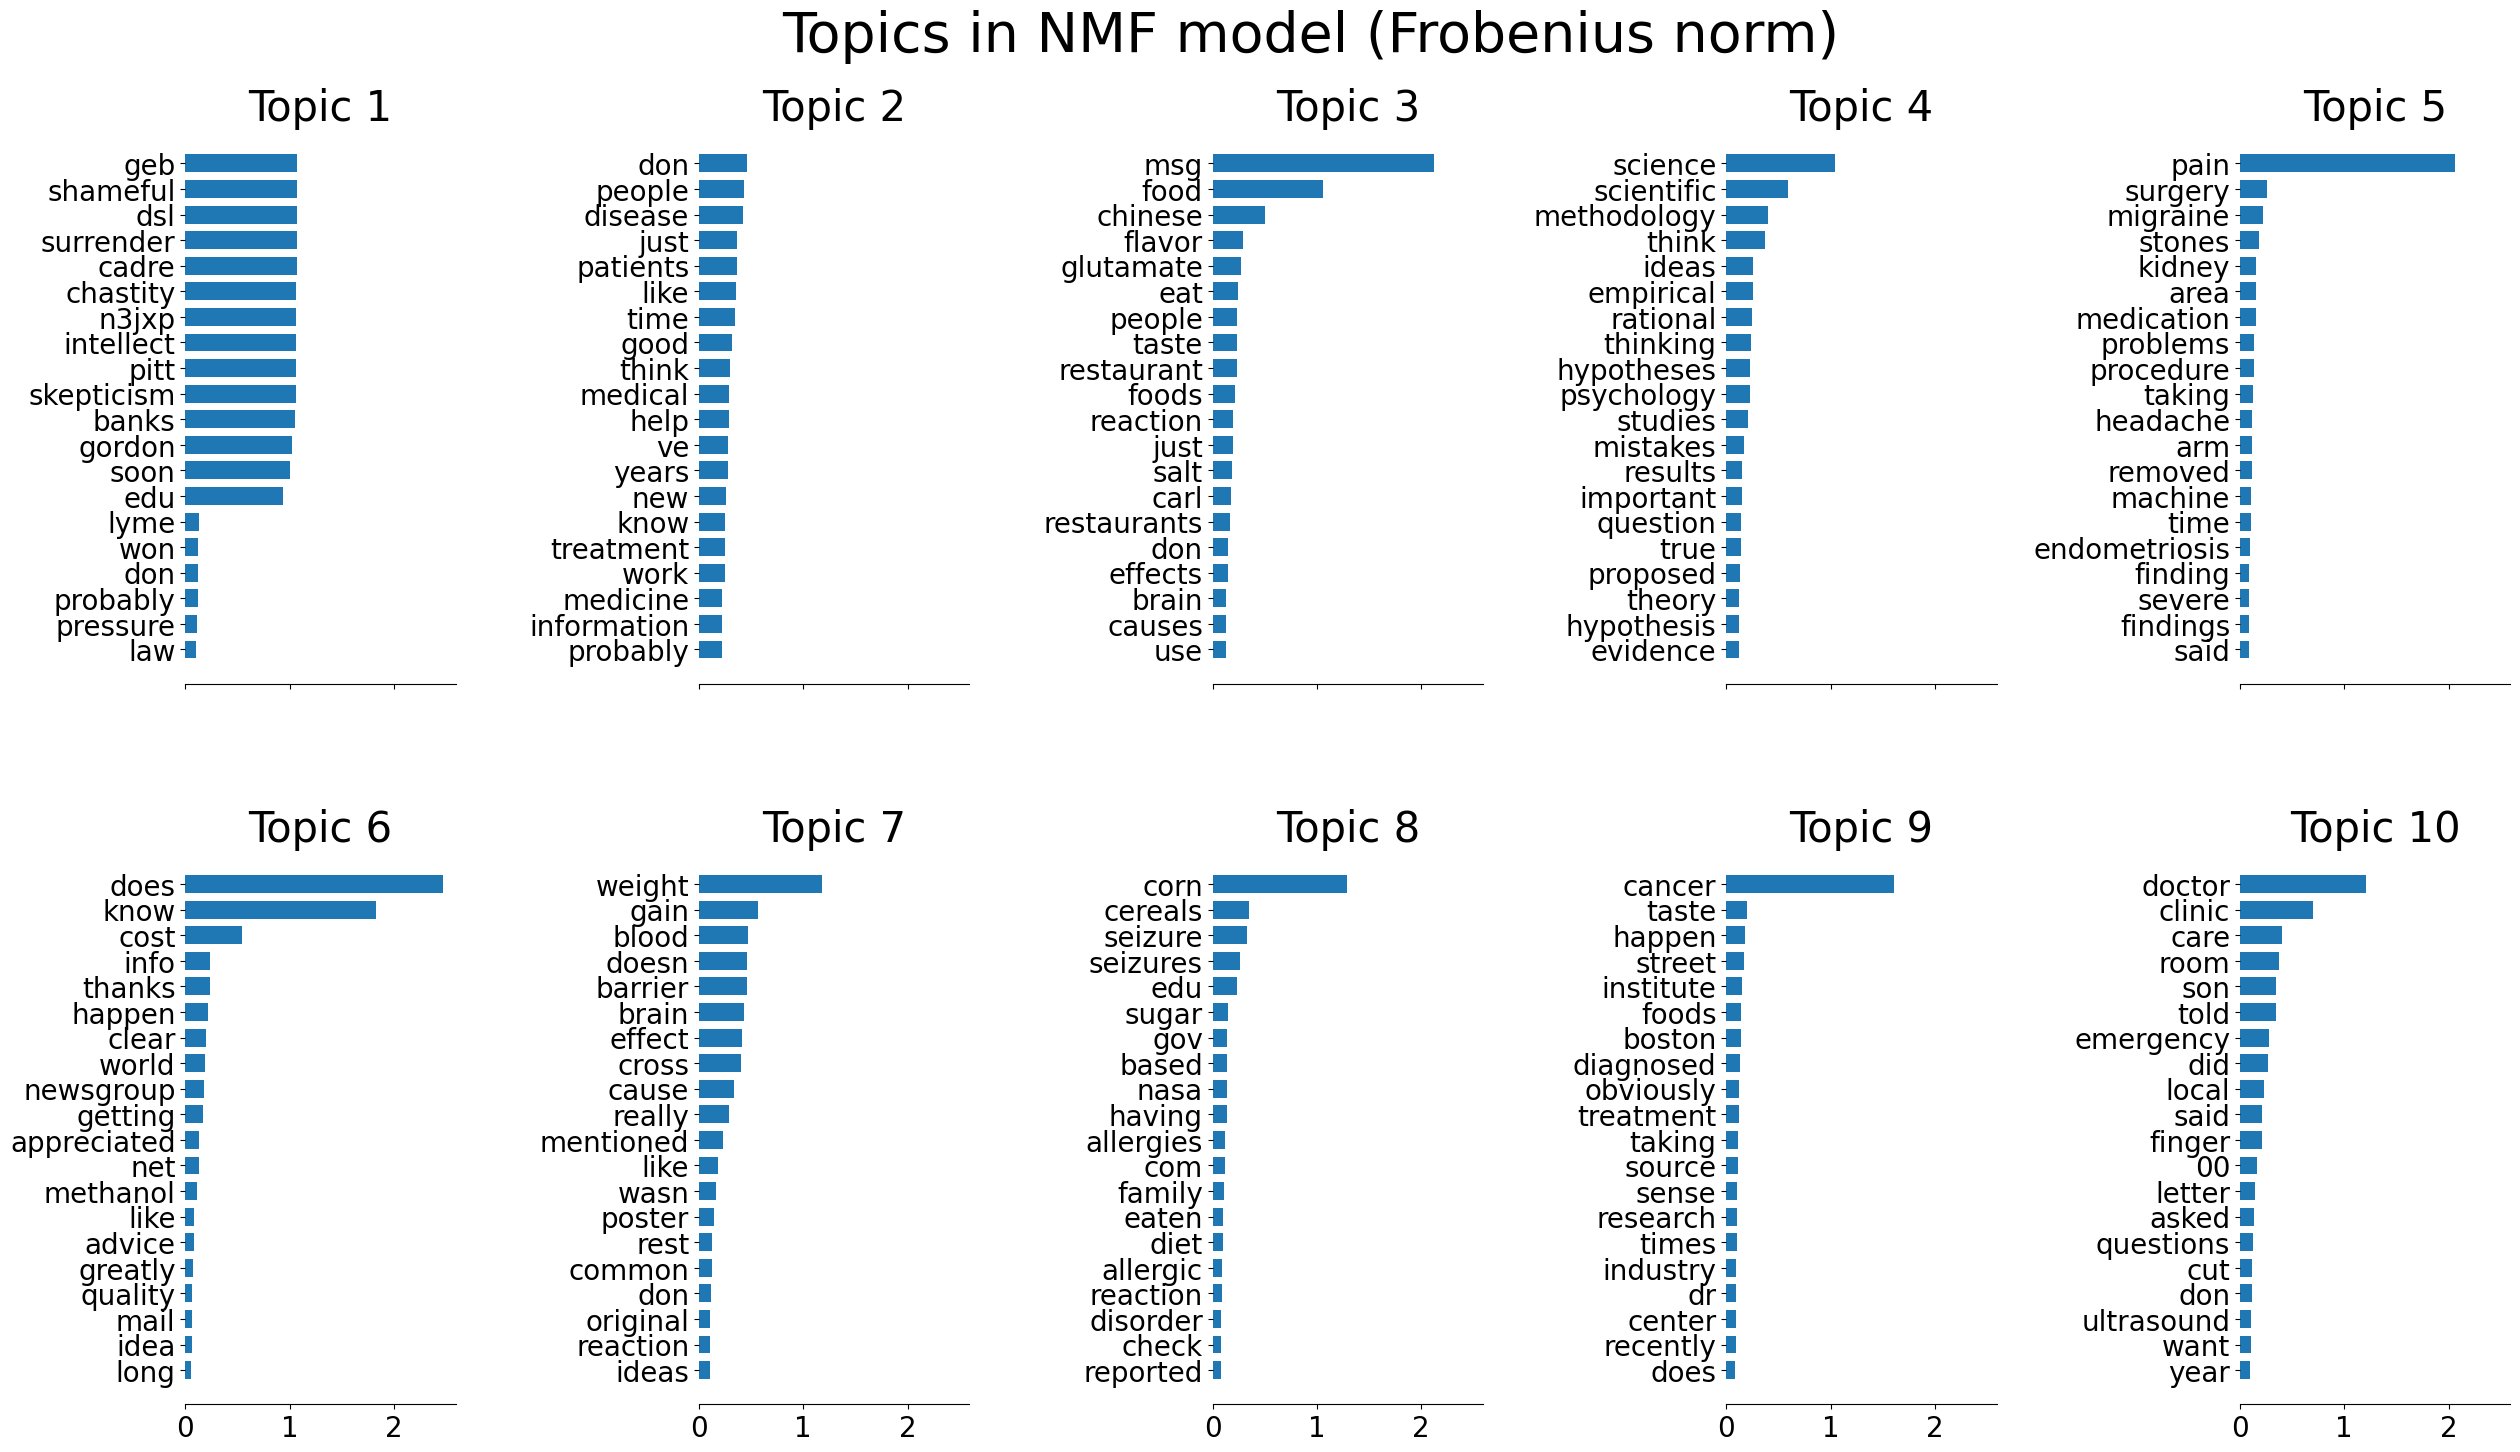

/tmp/ipython-input-1604644298.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


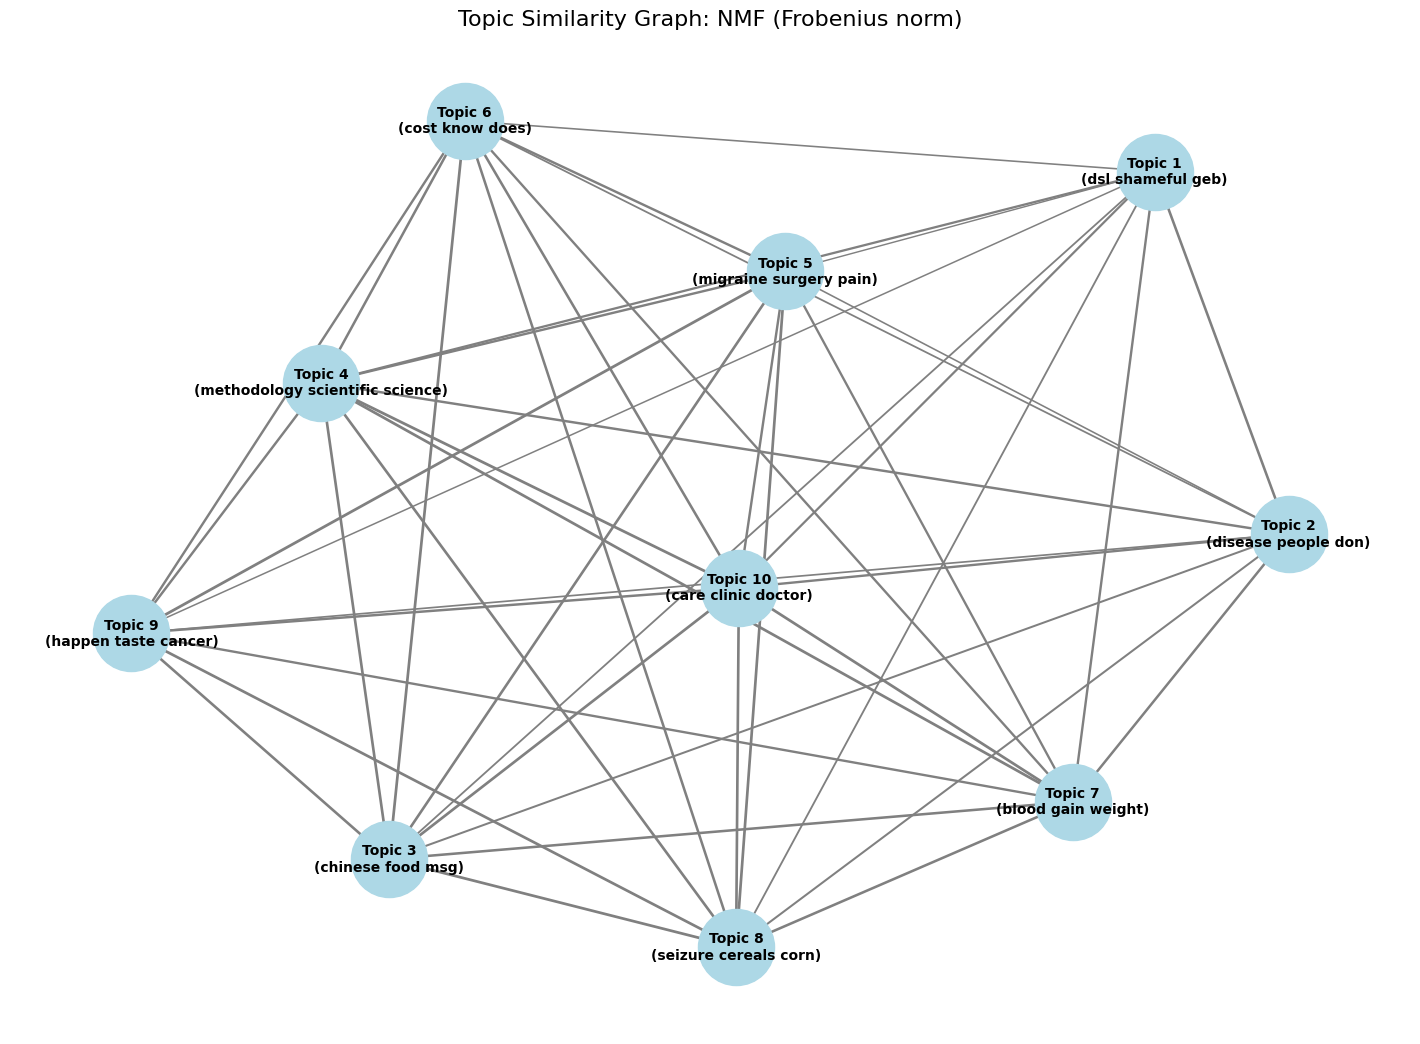



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=594 and n_features=1000...
done in 0.782s.


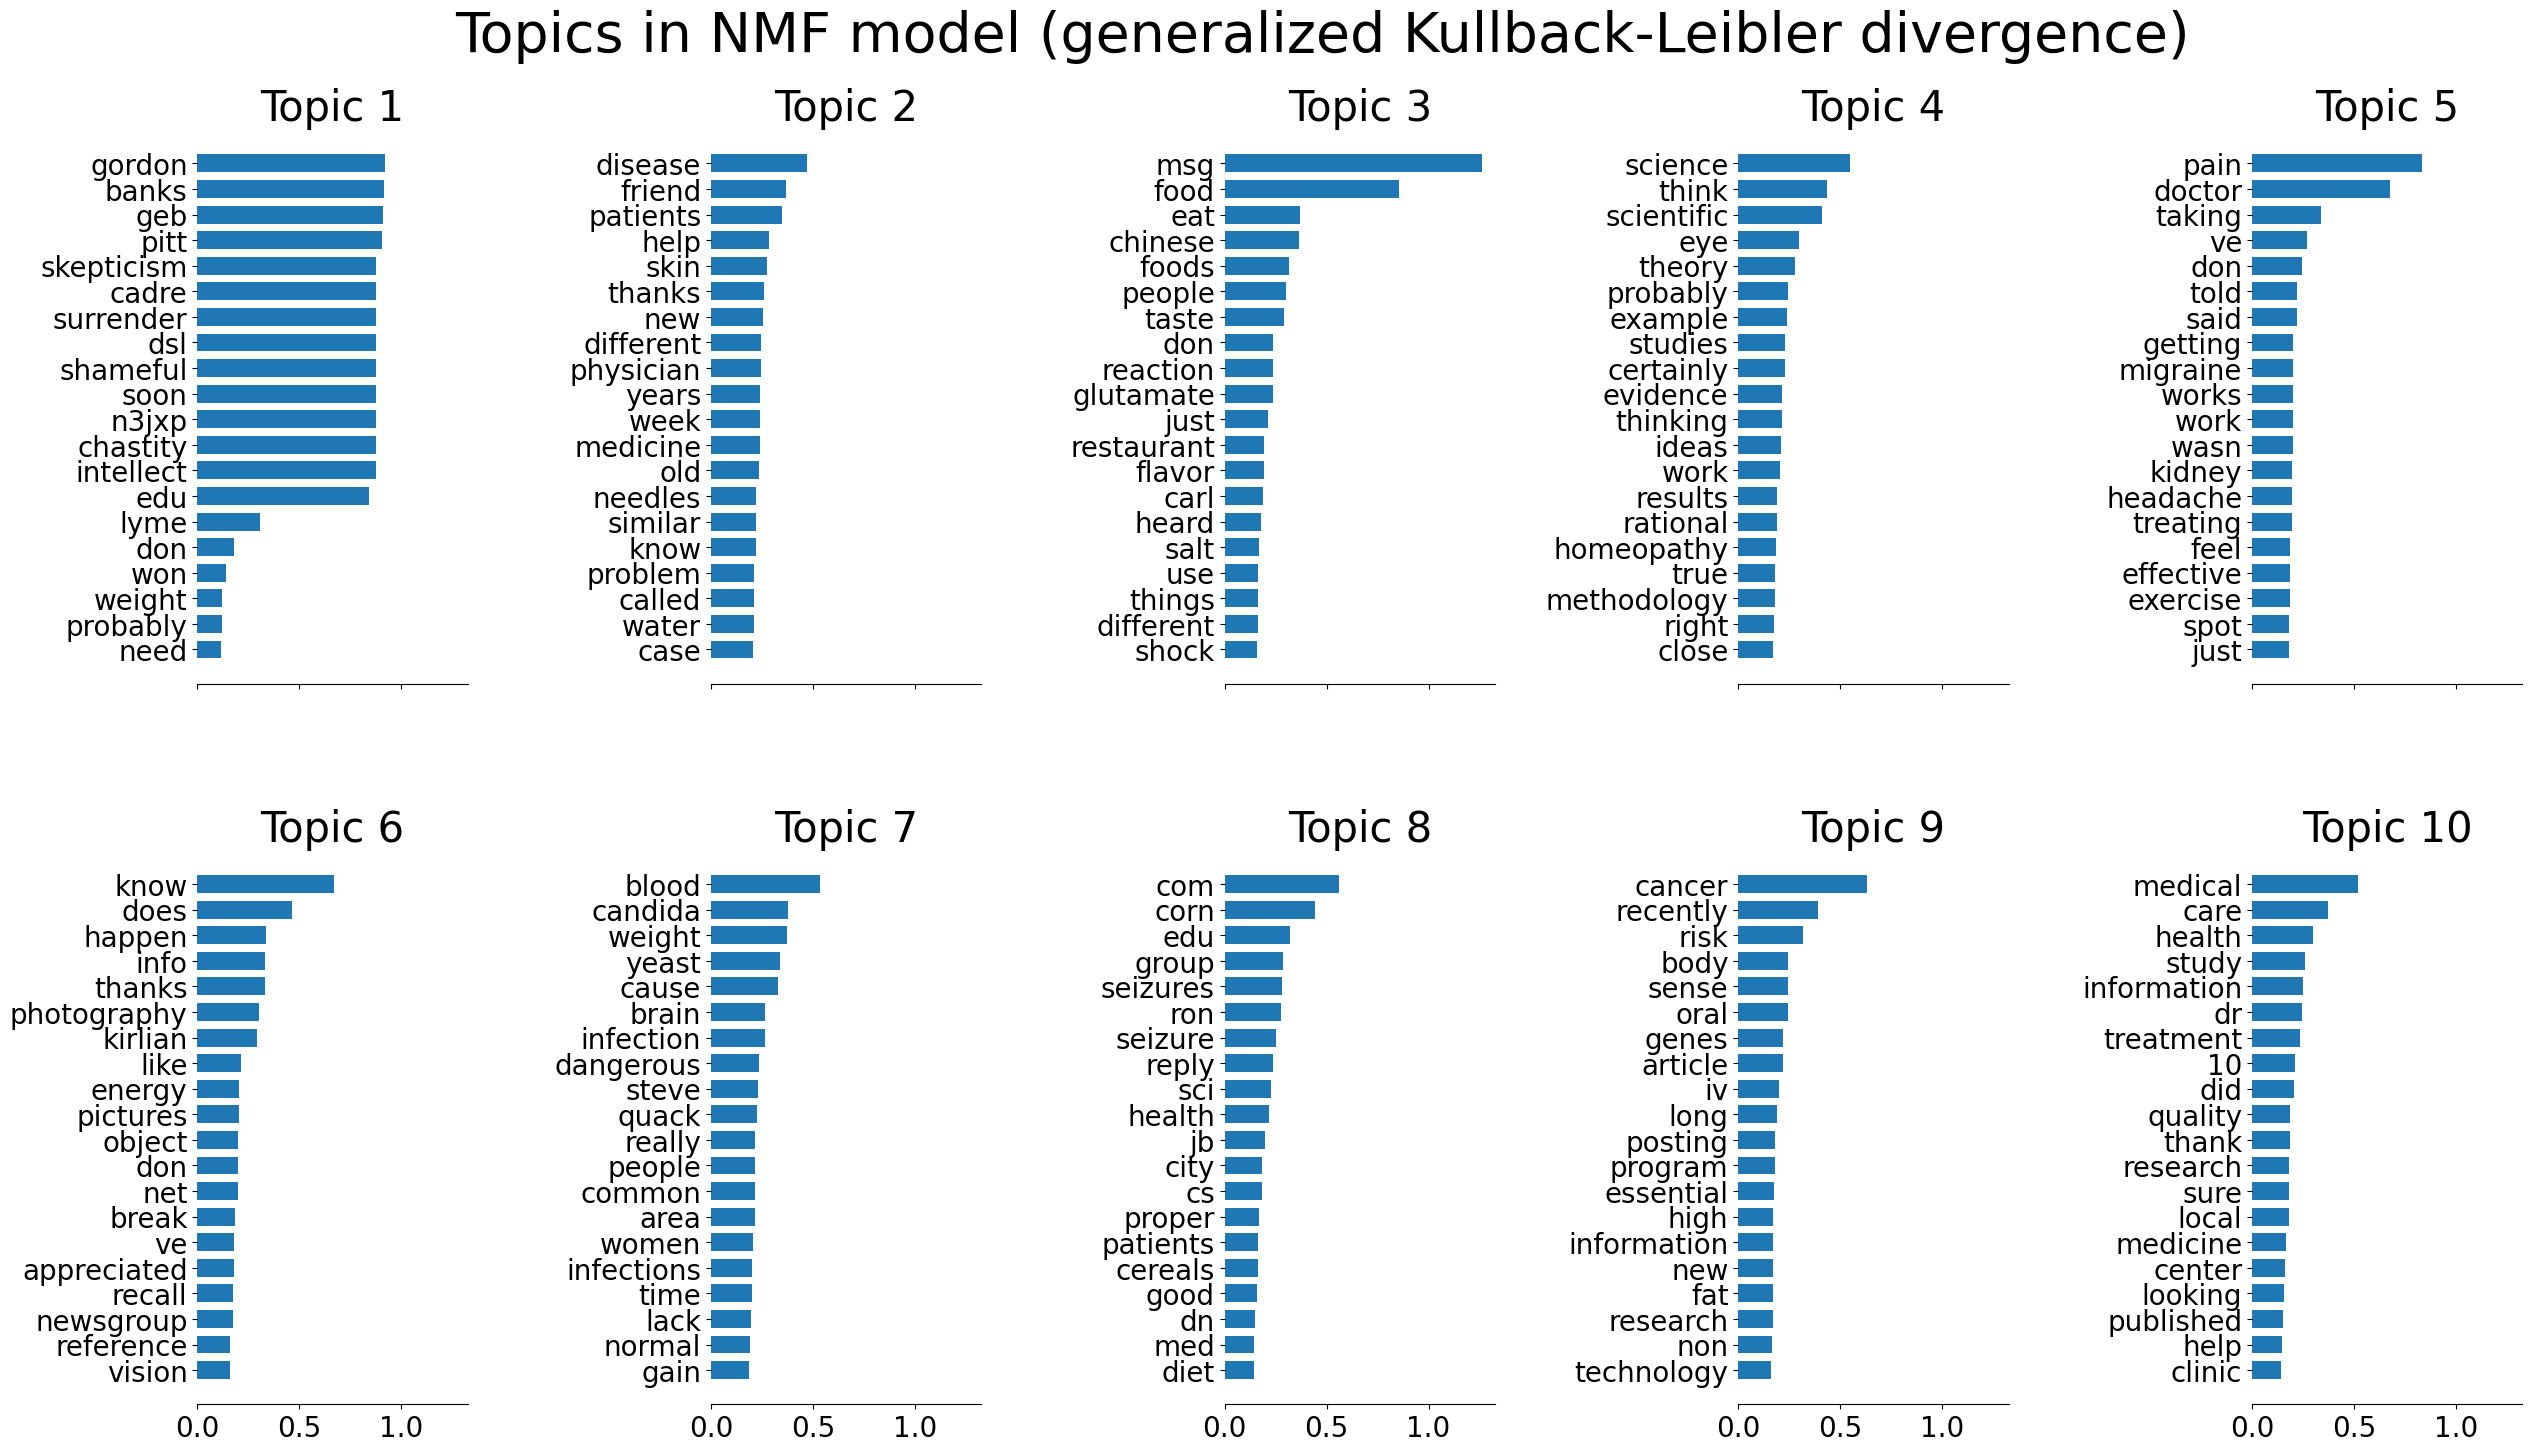

/tmp/ipython-input-1604644298.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


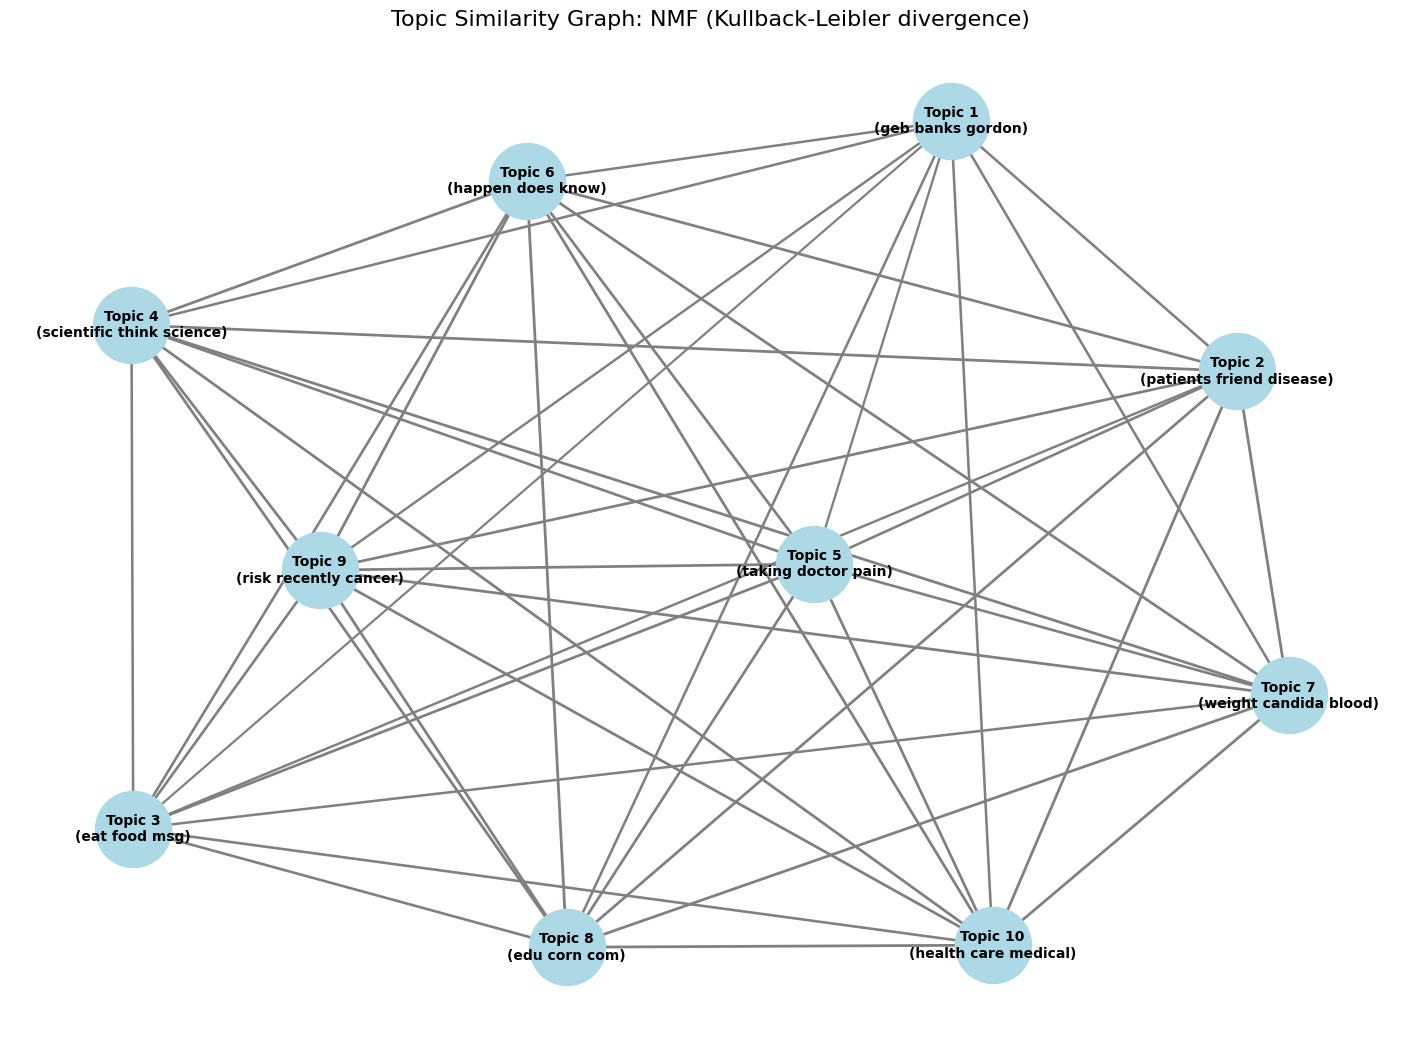



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=594 and n_features=1000, batch_size=128...
done in 0.730s.


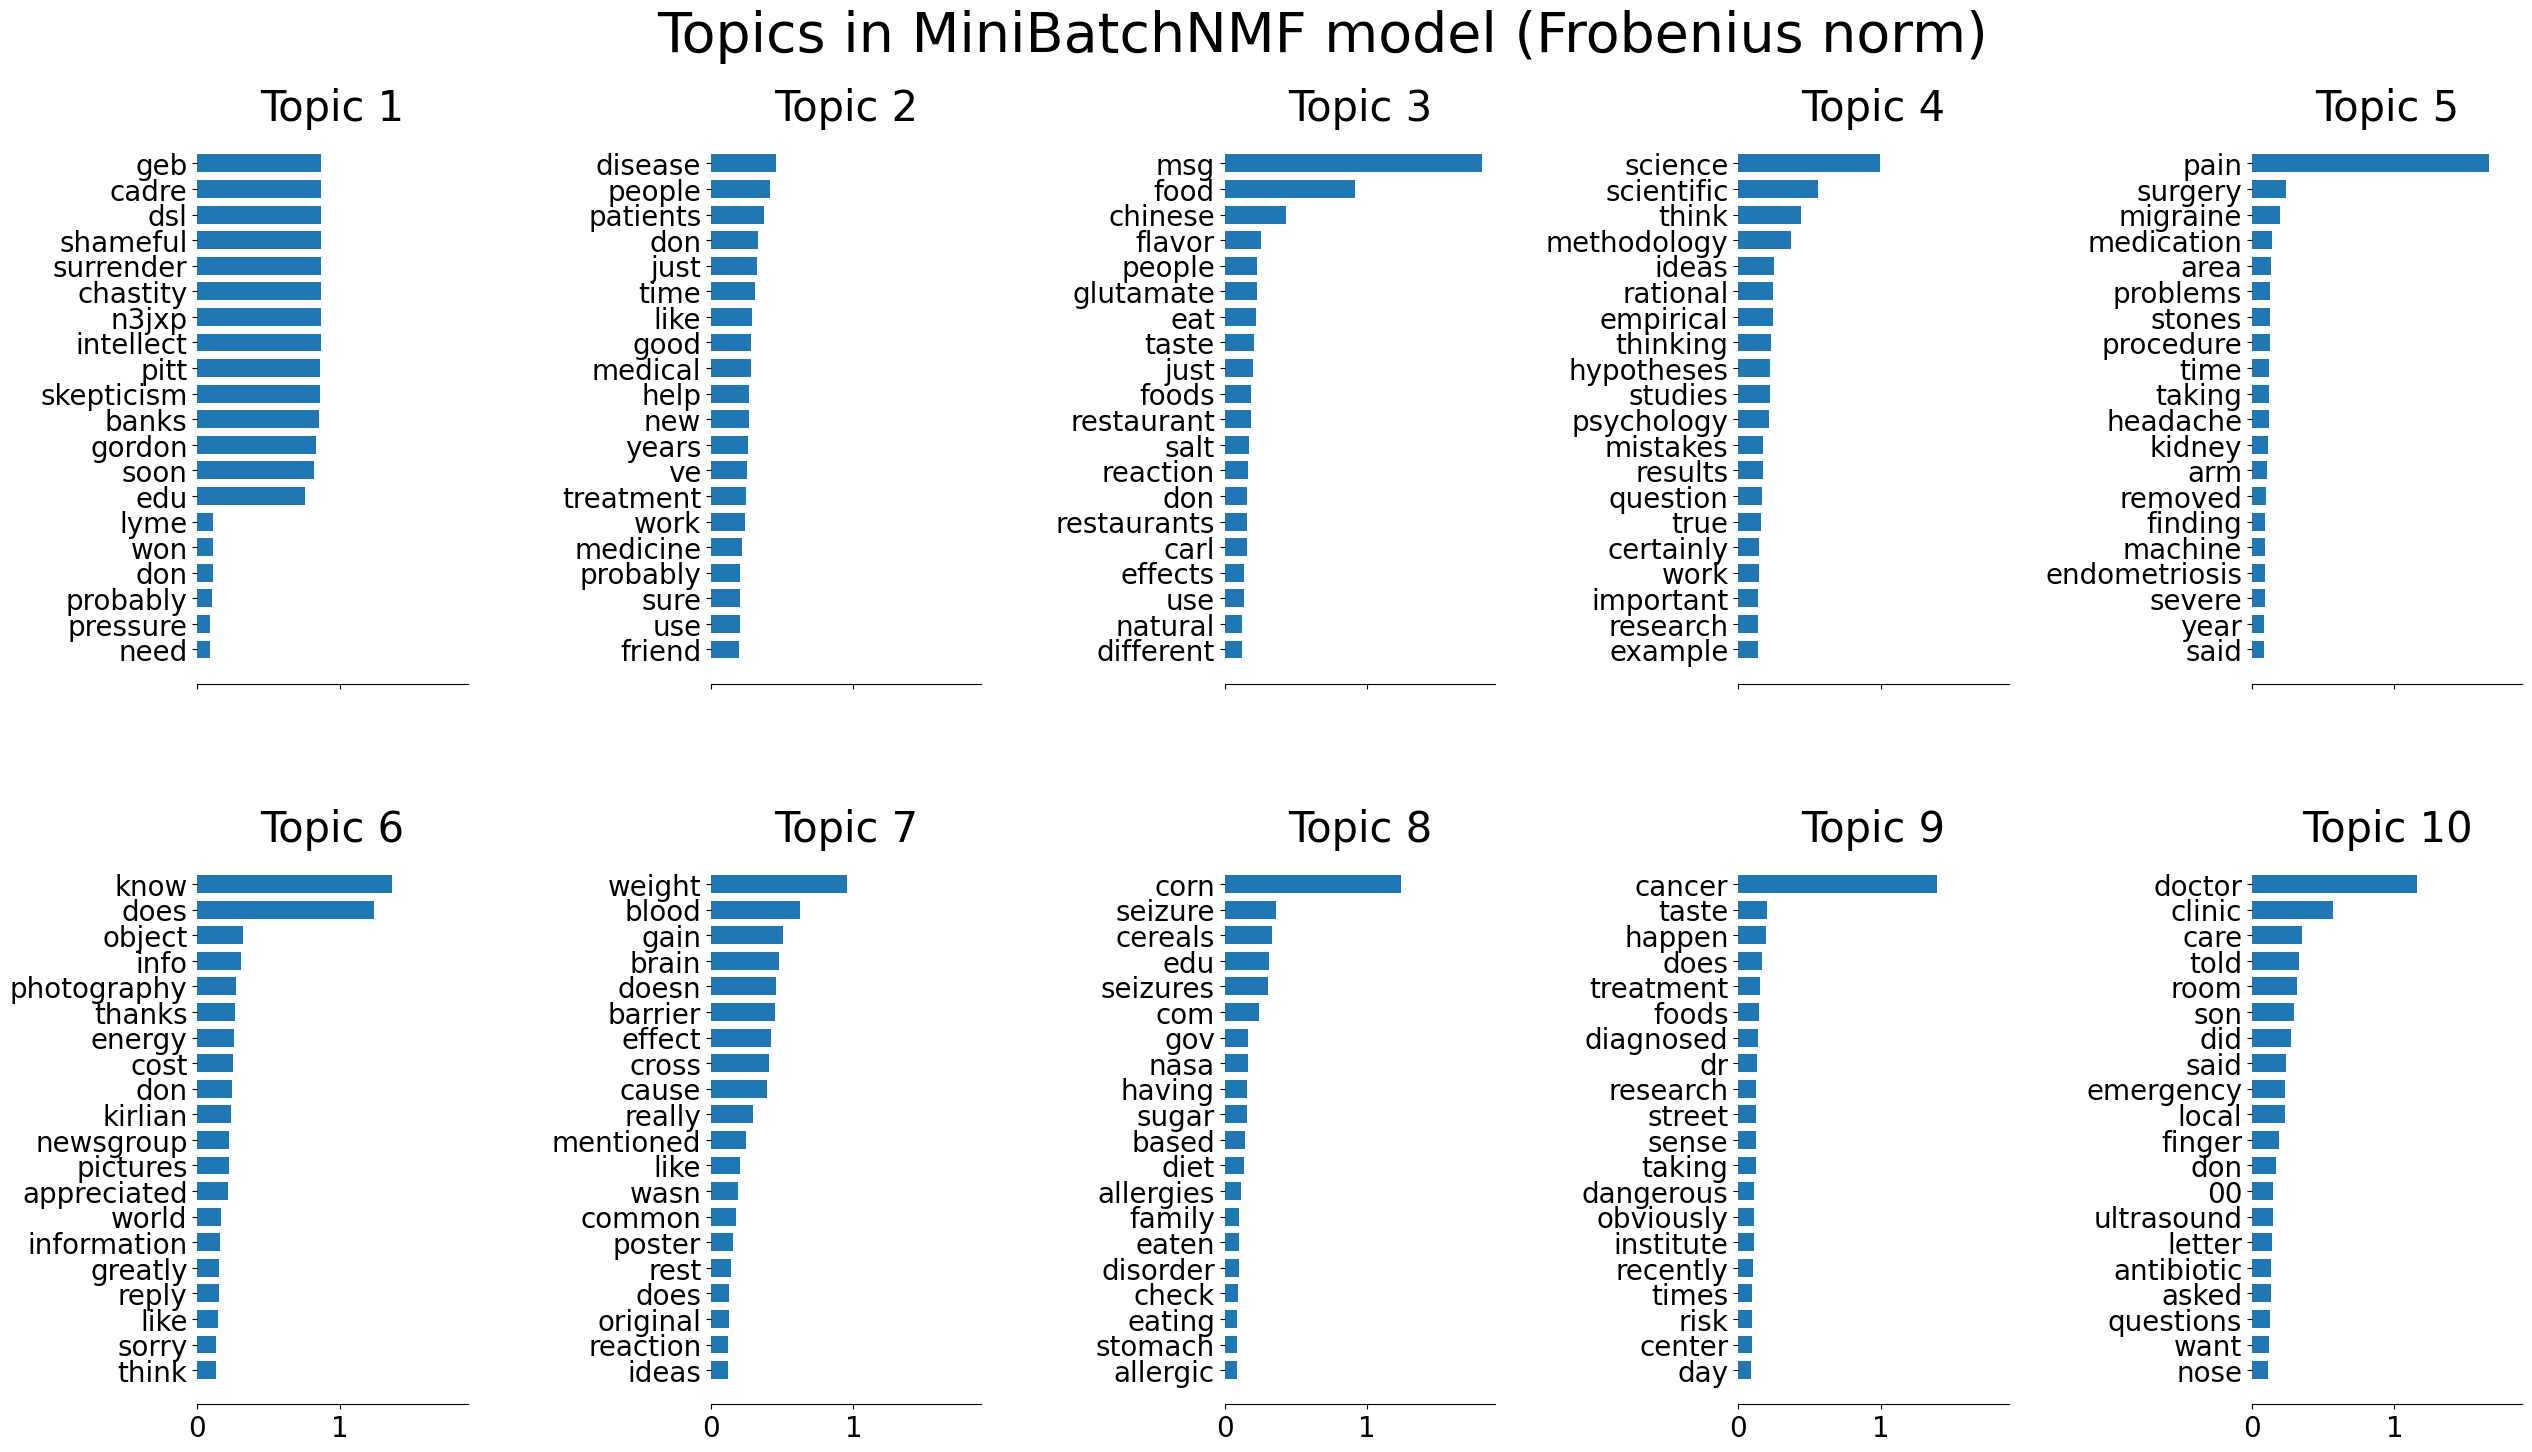

/tmp/ipython-input-1604644298.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


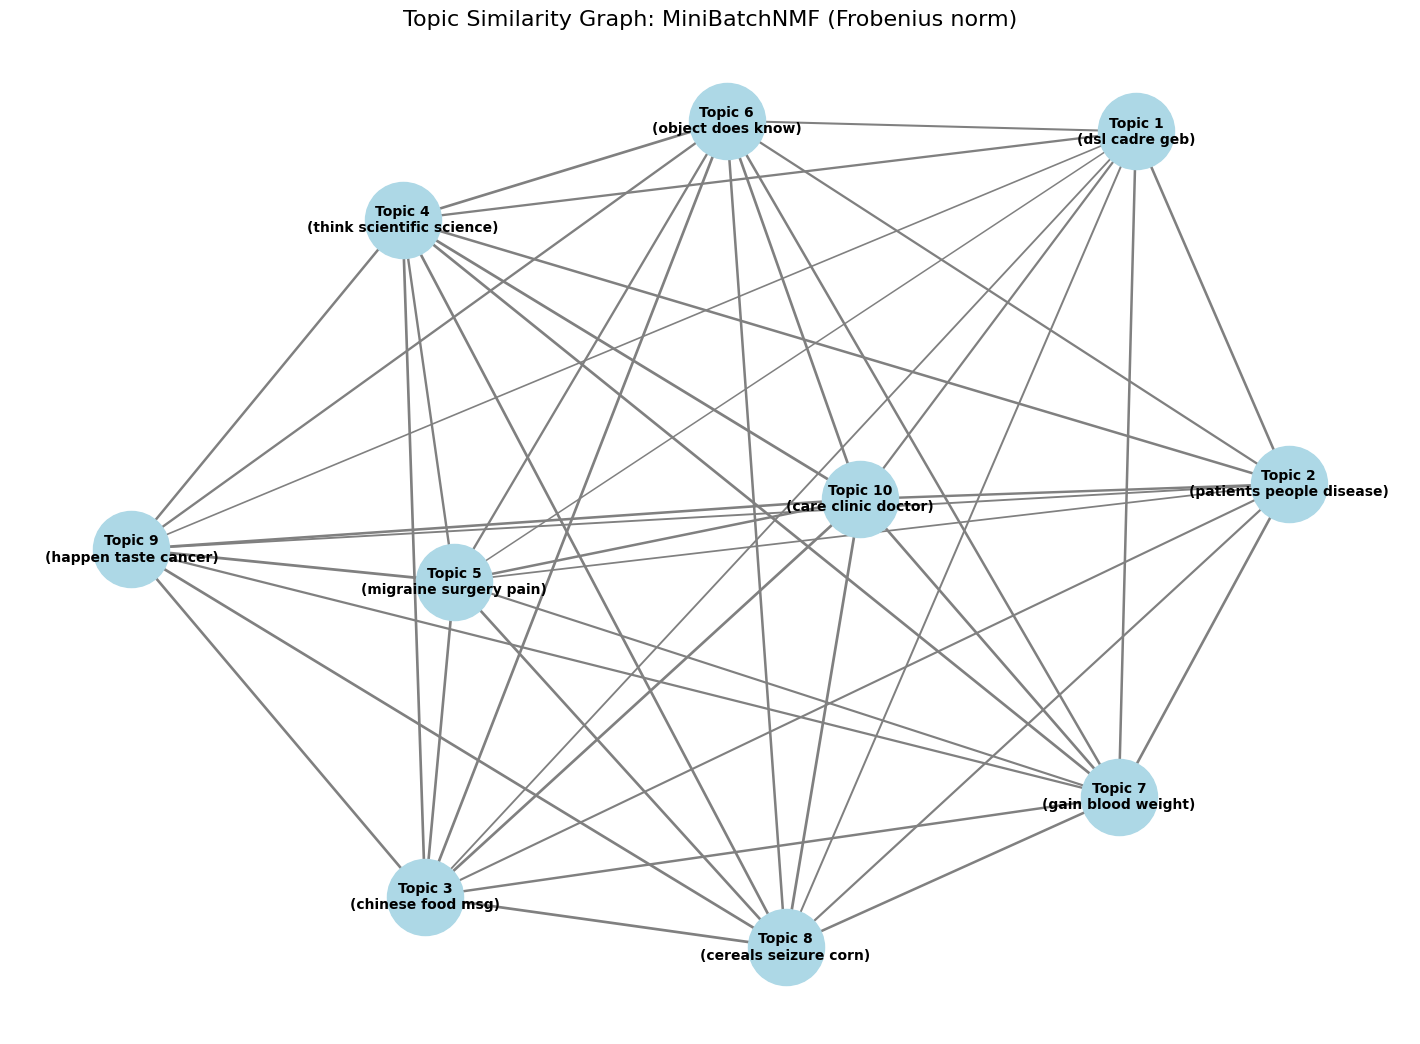



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=594 and n_features=1000, batch_size=128...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:2328: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 3.946s.


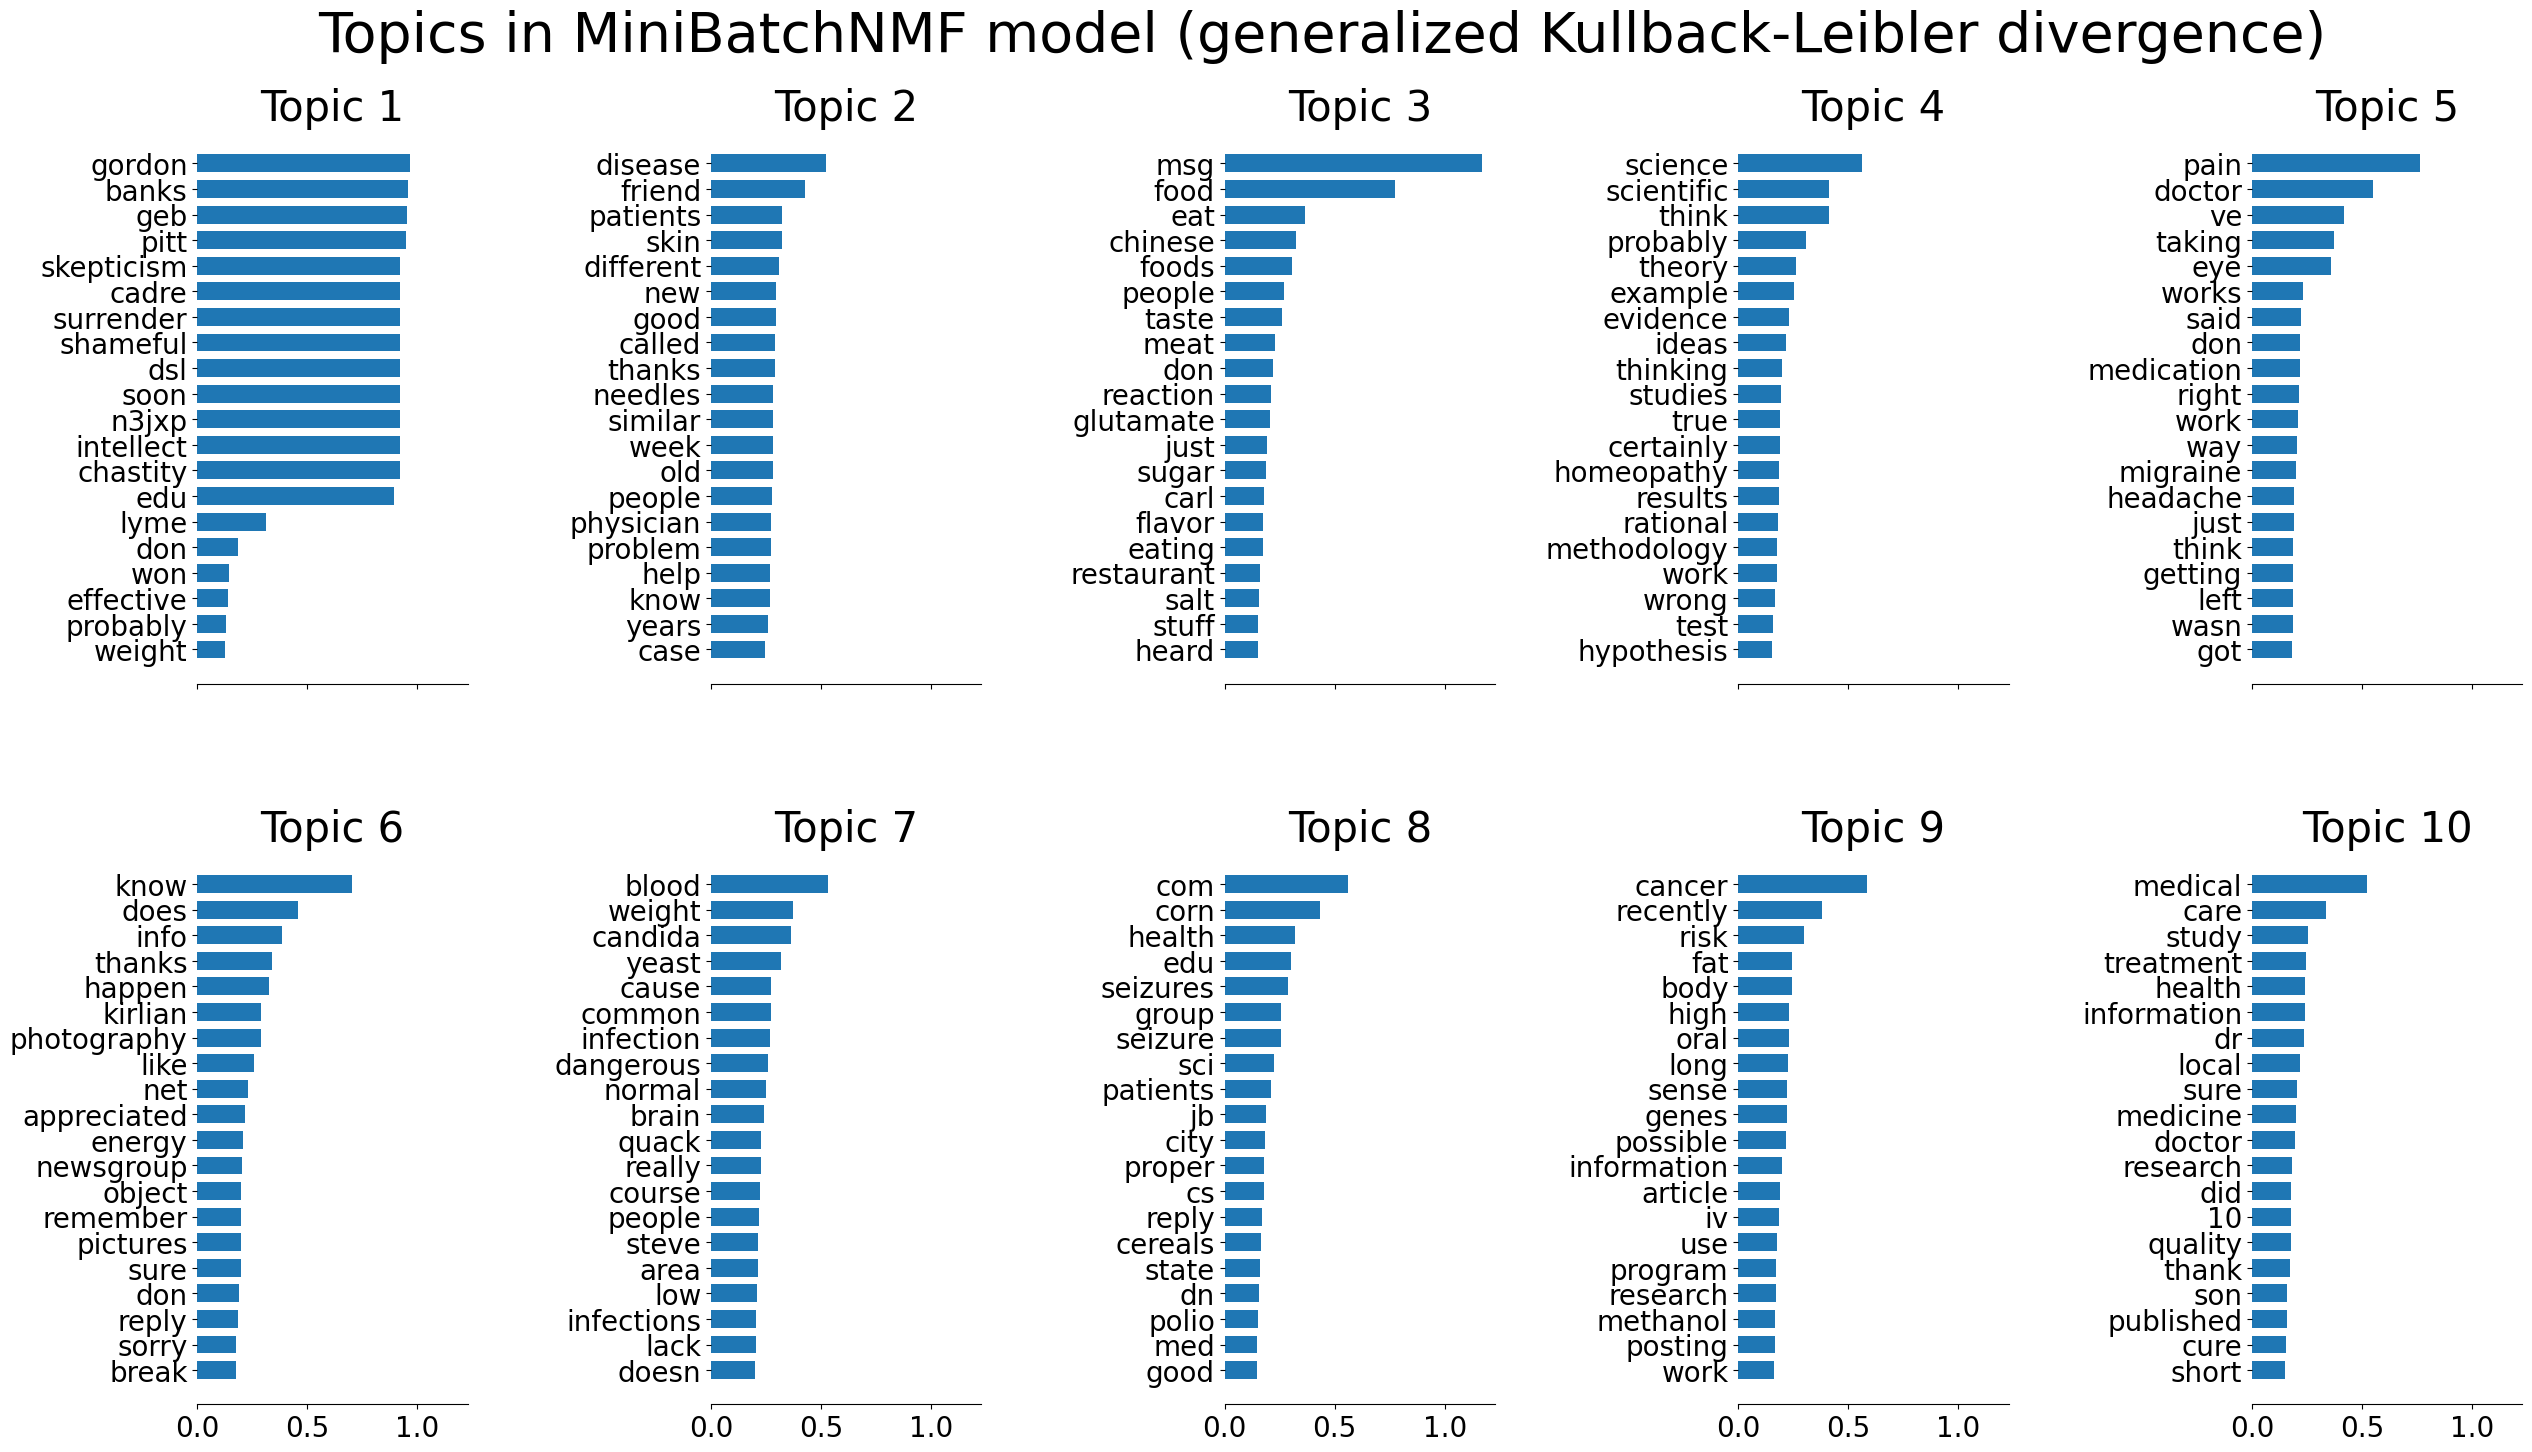

/tmp/ipython-input-1604644298.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


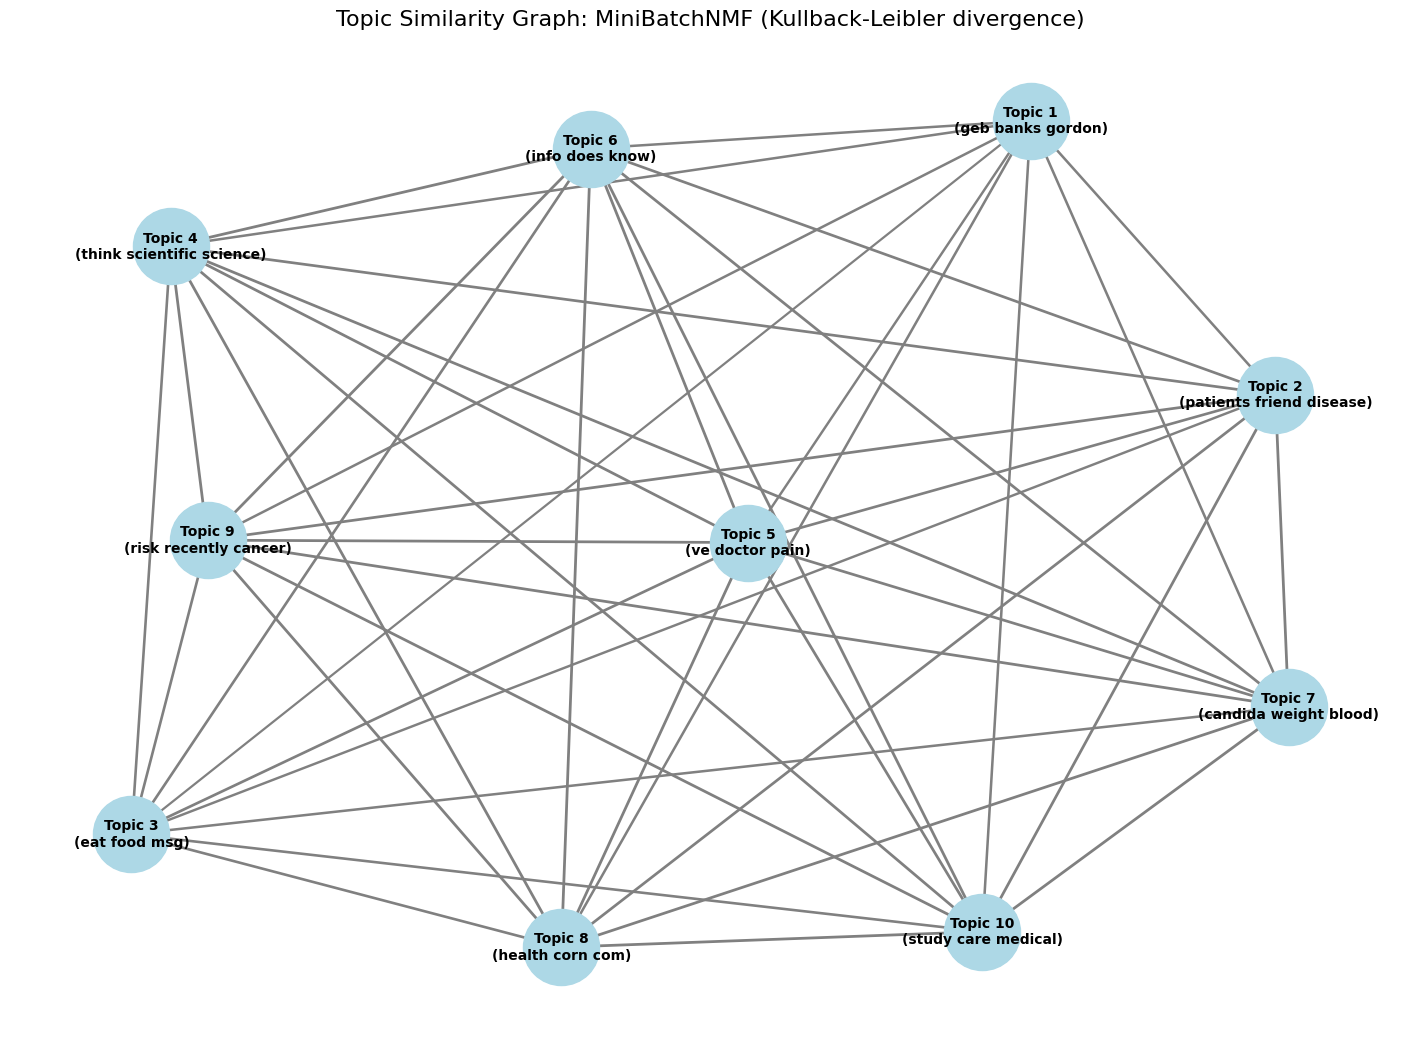



 Fitting LDA models with tf features, n_samples=594 and n_features=1000...
done in 1.124s.


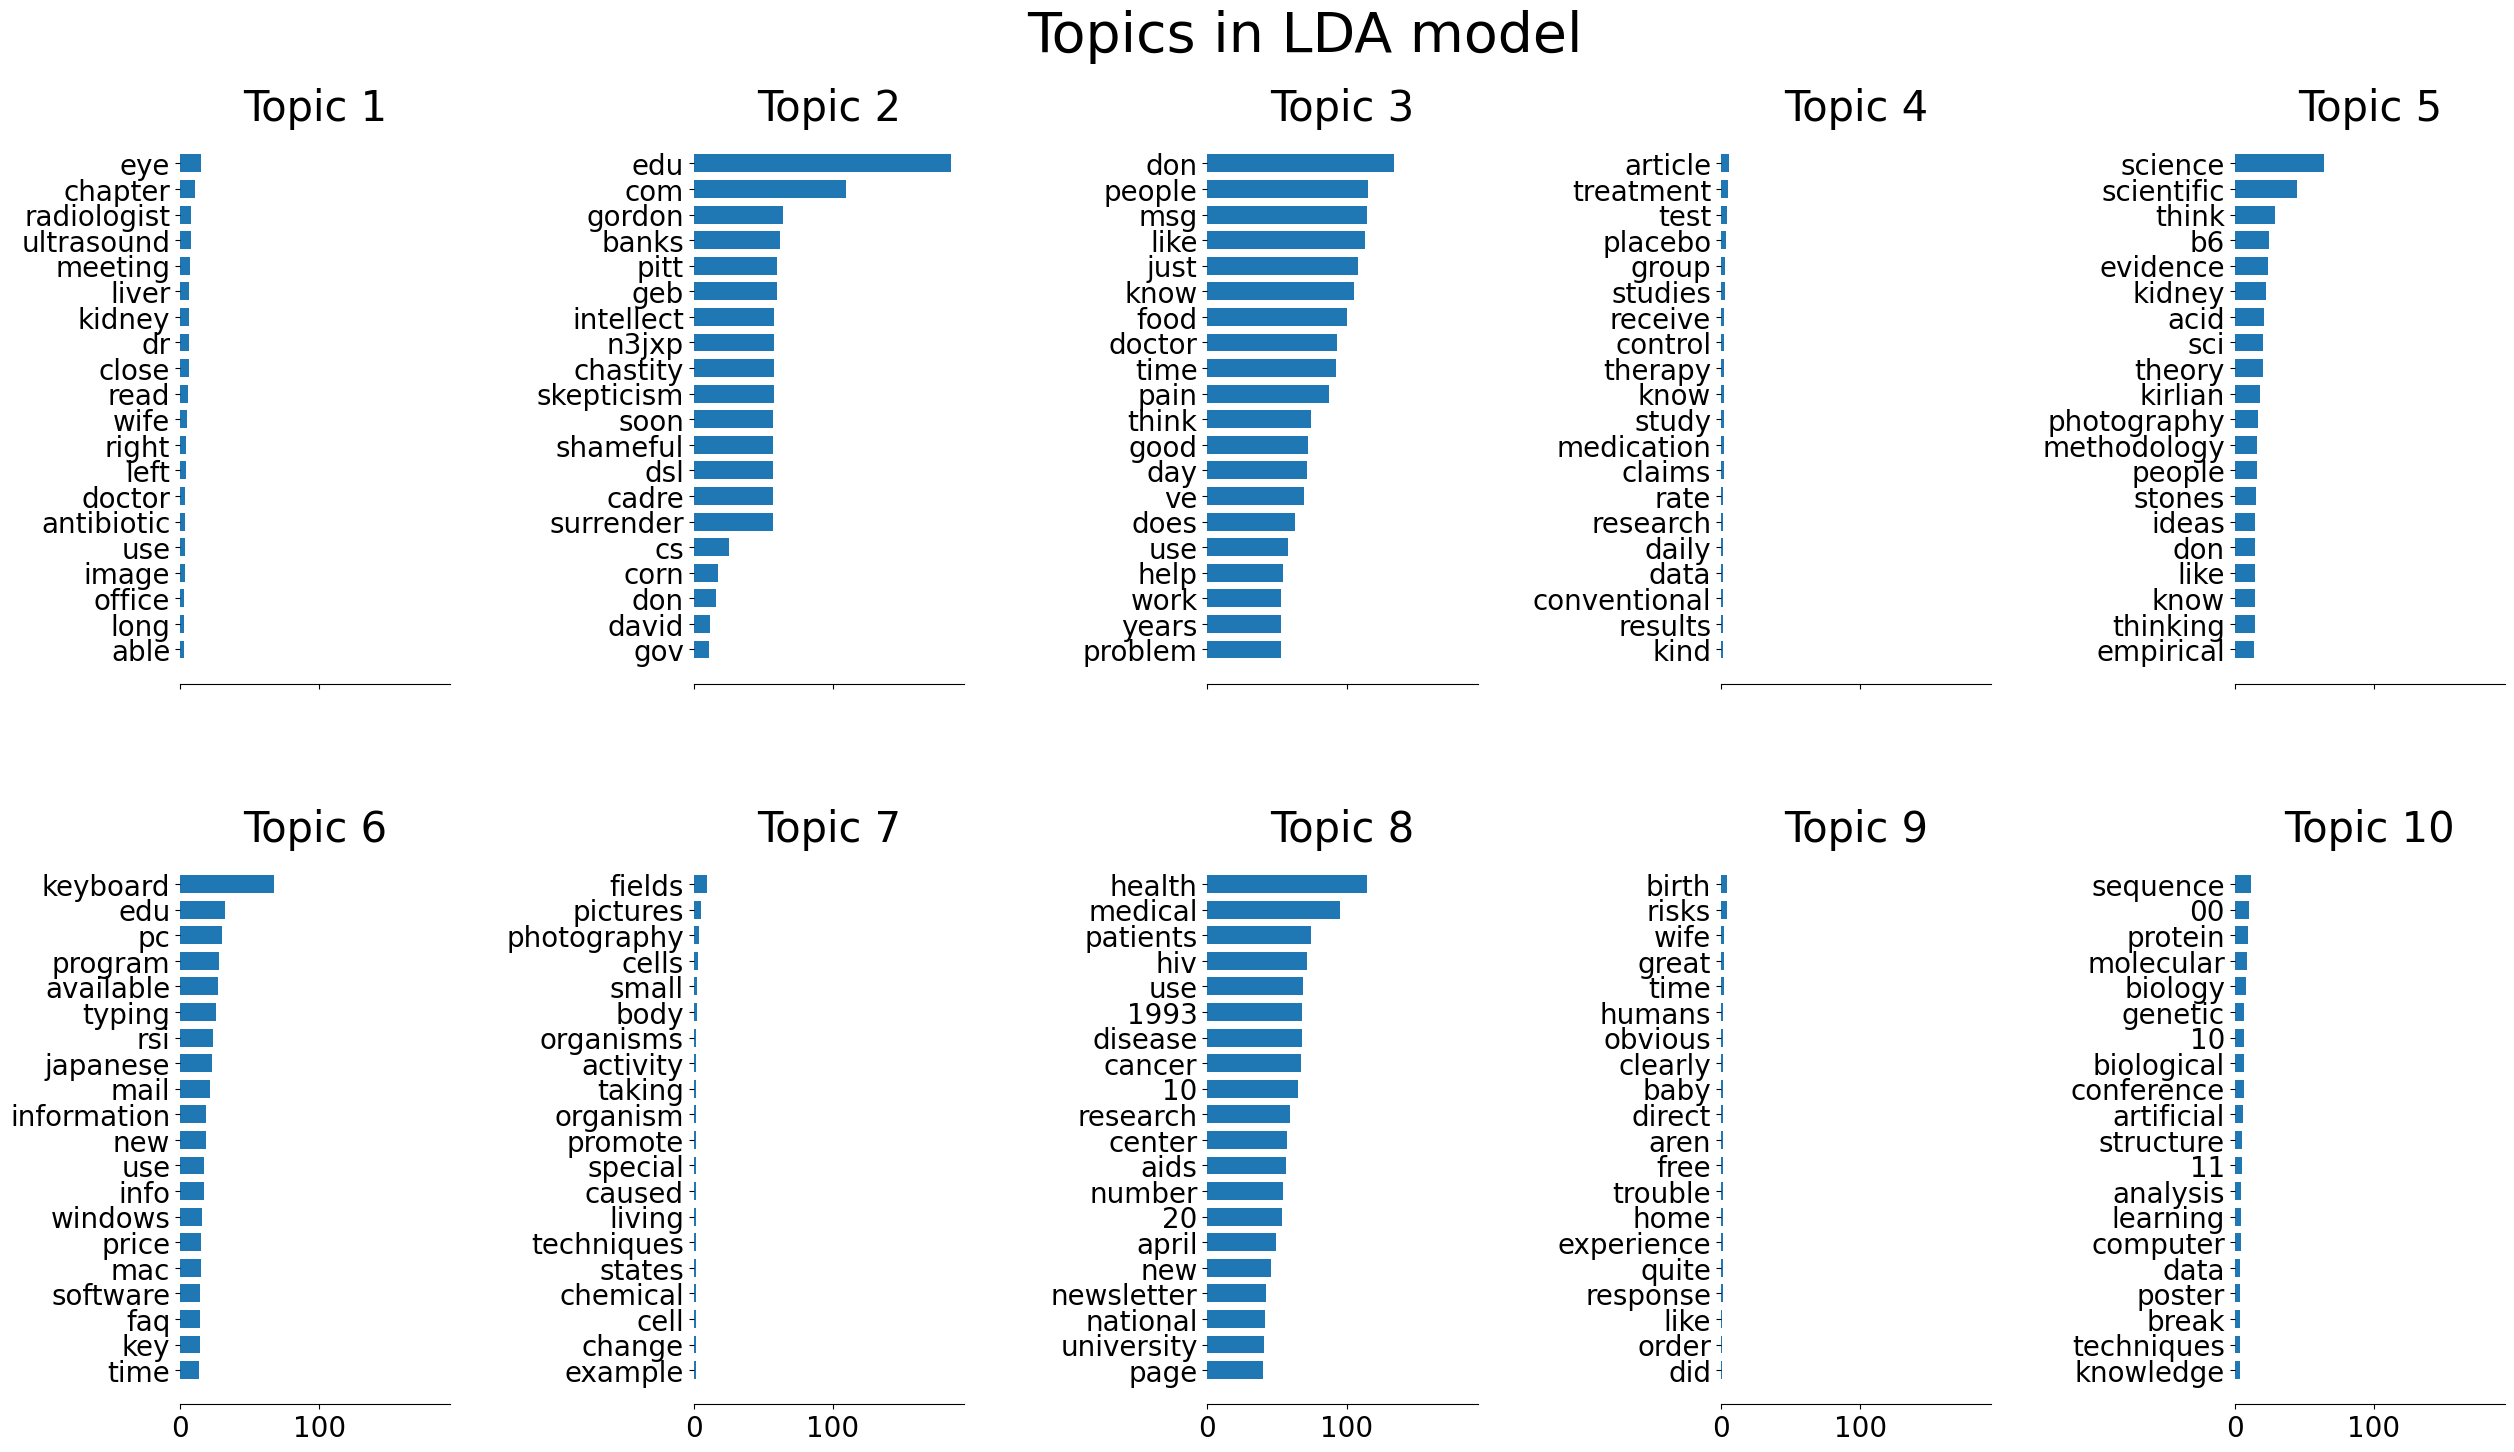

/tmp/ipython-input-1604644298.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


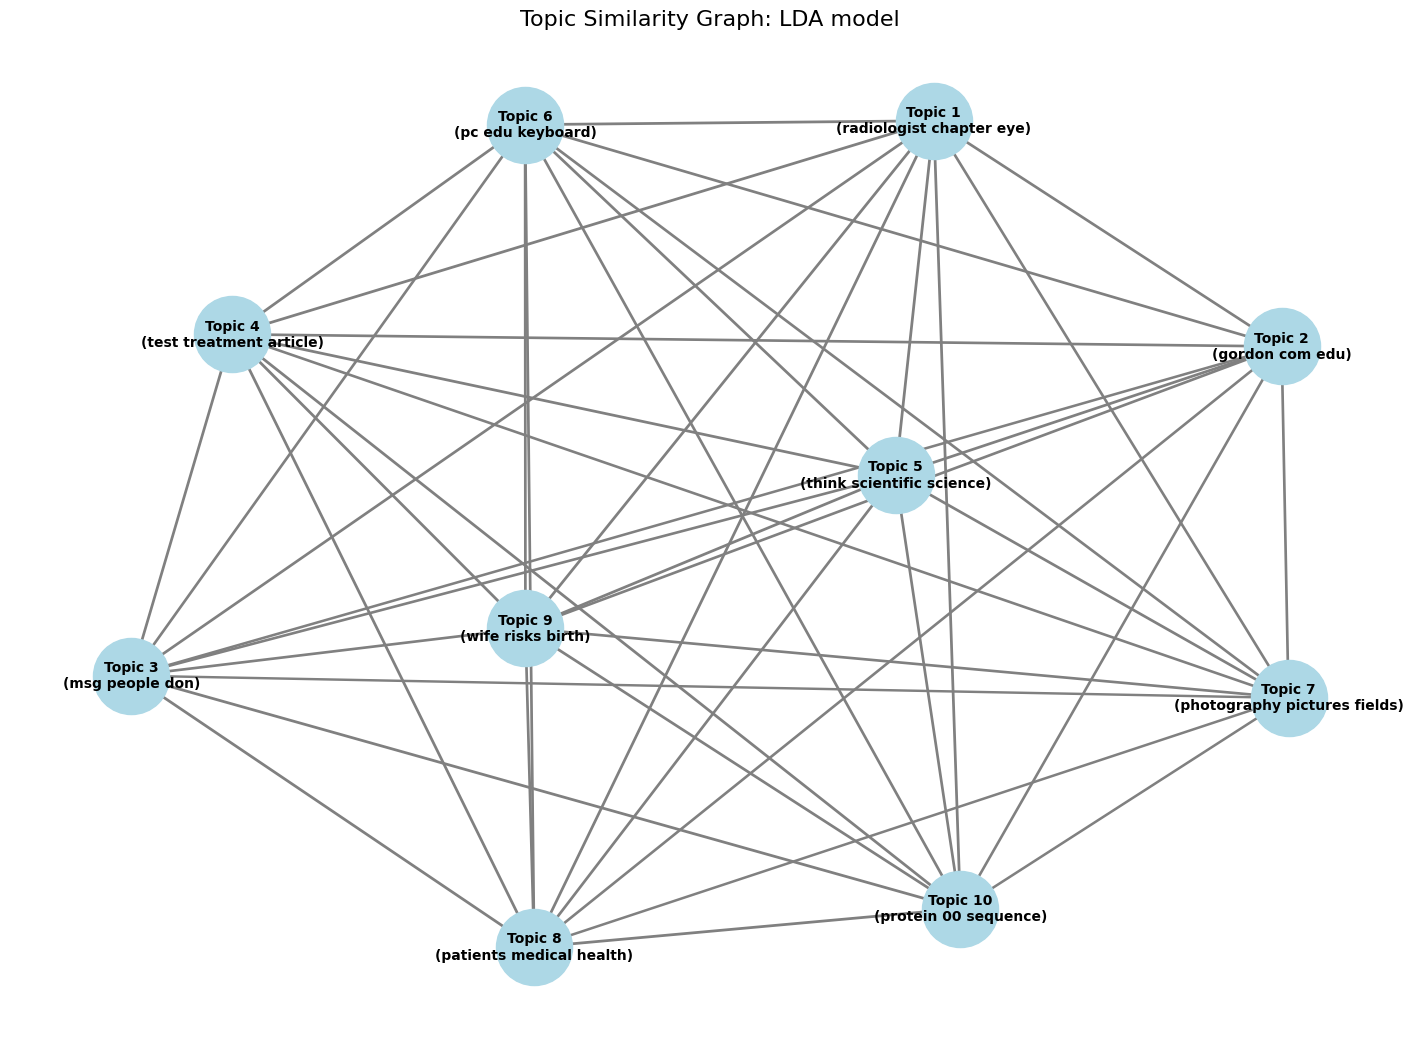

In [ ]:
# Authors: The scikit-learn developers (modified for medical data and graph visualization)
# SPDX-License-Identifier: BSD-3-Clause

from time import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx # Import NetworkX

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity # For calculating topic similarity

# --- Graph Visualization Helper Function ---
def plot_topic_graph(model, feature_names, n_top_words, title):
    """
    Creates and plots a graph where nodes are topics and edges represent
    similarity based on top words.
    """
    n_topics = model.n_components
    # Get top words and their weights for each topic
    top_word_indices_per_topic = []
    top_weights_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:]
        top_word_indices_per_topic.append(top_indices)
        top_weights_per_topic.append(topic[top_indices])

    # Calculate similarity matrix between topics based on top words
    # Use the weights of the top words for similarity calculation
    similarity_matrix = np.zeros((n_topics, n_topics))
    for i in range(n_topics):
        for j in range(n_topics):
            if i == j:
                similarity_matrix[i, j] = 1.0 # Self-similarity is 1
            else:
                # Cosine similarity between the weight vectors of top words
                weights_i = top_weights_per_topic[i]
                weights_j = top_weights_per_topic[j]
                # Use a simple average or weighted average if needed
                # Here we use the cosine similarity of the top word weight vectors
                sim = cosine_similarity(weights_i.reshape(1, -1), weights_j.reshape(1, -1))[0][0]
                similarity_matrix[i, j] = sim

    # Create NetworkX graph
    G = nx.Graph()
    G.add_nodes_from(range(n_topics))

    # Add edges based on similarity threshold
    threshold = 0.1 # Adjust this value to control graph density
    for i in range(n_topics):
        for j in range(i+1, n_topics): # Only check upper triangle to avoid duplicates
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    # Calculate layout positions
    pos = nx.spring_layout(G, seed=42) # Use spring layout for good visual distribution

    # Prepare node labels (Topic names based on top words)
    node_labels = {}
    for topic_idx in range(n_topics):
        top_features_ind = model.components_[topic_idx].argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        # Create a simple label from top 3 words
        label = " ".join(top_features[-3:])
        node_labels[topic_idx] = f"Topic {topic_idx + 1}\n({label})"

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw(G, pos,
            with_labels=True,
            labels=node_labels,
            node_color='lightblue',
            node_size=3000,
            edge_color='gray',
            width=[d['weight']*2 for (u,v,d) in G.edges(data=True)], # Edge width based on weight
            font_size=10,
            font_weight='bold',
            verticalalignment='center', # Align labels better
            horizontalalignment='center'
           )
    plt.title(f"Topic Similarity Graph: {title}", size=16)
    plt.axis('off') # Turn off axis for cleaner look
    plt.tight_layout()
    plt.show()

# --- Original plot_top_words function (for word bars) ---
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# --- Data Loading ---
print("Loading medical dataset...")
t0 = time()

# Fetch medical-related newsgroups
medical_categories = ['sci.med'] # Focus on medical content
try:
    data, target = fetch_20newsgroups(
        shuffle=True,
        random_state=1,
        remove=("headers", "footers", "quotes"),
        categories=medical_categories,
        return_X_y=True,
    )
except ValueError:
    # Fallback if specific category not available
    print("Medical category 'sci.med' not found, using all data...")
    data, target = fetch_20newsgroups(
        shuffle=True,
        random_state=1,
        remove=("headers", "footers", "quotes"),
        return_X_y=True,
    )

n_samples = min(2000, len(data))
data_samples = data[:n_samples]
print(f"Loaded {n_samples} medical-related documents in %0.3fs." % (time() - t0))

# --- Parameters ---
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

# --- Feature Extraction ---
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# --- Model Fitting and Visualization ---
# --- NMF (Frobenius) ---
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf_fro = NMF( # Renamed for clarity
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot word bars
plot_top_words(
    nmf_fro, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Plot topic graph
plot_topic_graph(
    nmf_fro, tfidf_feature_names, n_top_words, "NMF (Frobenius norm)"
)


# --- NMF (KL Divergence) ---
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf_kl = NMF( # Renamed for clarity
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot word bars
plot_top_words(
    nmf_kl,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Plot topic graph
plot_topic_graph(
    nmf_kl, tfidf_feature_names, n_top_words, "NMF (Kullback-Leibler divergence)"
)


# --- MiniBatchNMF (Frobenius) ---
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf_fro = MiniBatchNMF( # Renamed for clarity
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot word bars
plot_top_words(
    mbnmf_fro,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Plot topic graph
plot_topic_graph(
    mbnmf_fro, tfidf_feature_names, n_top_words, "MiniBatchNMF (Frobenius norm)"
)


# --- MiniBatchNMF (KL Divergence) ---
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf_kl = MiniBatchNMF( # Renamed for clarity
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Plot word bars
plot_top_words(
    mbnmf_kl,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

# Plot topic graph
plot_topic_graph(
    mbnmf_kl, tfidf_feature_names, n_top_words, "MiniBatchNMF (Kullback-Leibler divergence)"
)


# --- LDA ---
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()

# Plot word bars
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# Plot topic graph
plot_topic_graph(lda, tf_feature_names, n_top_words, "LDA model")